In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.6 MB/s eta 0:00:00


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Progress bar
import dill

import sys
sys.setrecursionlimit(10000)
sys.path.append('/content/drive/MyDrive/!ML/tubes 1/Tubes_ML_1-main/src')

from ValueTensor import Value, ValueTensor, criterion
from Layer import initialization, Layer, OutputLayer
from model import FFNN

In [2]:
import numpy as np

class Value:
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data               # Data value
    self.grad = 0                  # Grad initialization = 0
    self._backward = lambda: None  # Local backward function
    self._prev = set(_children)    # Previous Values
    self._op = _op                 # Operator
    self.label = label             # Label (variabel name, e.g., x, net, o, h)

  # Data display when printed
  def __repr__(self):
    return f"Value({self.data})"

  # Multiply operator
  def __mul__(self, other):
    # self * other
    if isinstance(other, ValueTensor):
      return other + self
    elif isinstance(other, Value):
      other = other
    else:
      other = Value(other)

    out = Value(self.data * other.data, (self, other), "*")

    # Local backpropagation (derivative of out w.r.t self and other)
    def _backward():
      other.grad += self.data * out.grad
      self.grad += other.data * out.grad

    out._backward = _backward  # add _backward function to Value out

    return out

  def abs(self):
    out = Value(np.abs(self.data), (self,), "abs")

    def _backward():
      self.grad += np.sign(self.data) * out.grad
    out._backward = _backward

    return out

  # Reverse multiply operator
  def __rmul__(self, other):
    # other * self
    return self * other

  # Power operator
  def __pow__(self, other):
    # self**other
    if isinstance(other, (int, float)):
      other = other
    elif isinstance(other, Value):
      other = float(other.data)
    else:
      other = float(other)

    out = Value(self.data**other, (self,), f"**{other}")

    def _backward():
      self.grad += other * (self.data**(other - 1)) * out.grad

    out._backward = _backward

    return out

  def __rpow__(self, other):
    # other**self
    if isinstance(other, (int, float)):
      other = other
    elif isinstance(other, Value):
      other = float(other.data)
    else:
      other = float(other)

    out = Value(other**self.data, (self,), f"{other}**")

    def _backward():
      self.grad += out.data * np.log(other) * out.grad

    out._backward = _backward

    return out

  # Add operator
  def __add__(self, other):
    # self + other
    if isinstance(other, ValueTensor):
      return other + self
    elif isinstance(other, Value):
      other = other
    else:
      other = Value(other)

    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      other.grad += out.grad
      self.grad += out.grad

    out._backward = _backward

    return out

  # reverse add operator
  def __radd__(self, other):
    # other + self
    return self + other

  # negative operator
  def __neg__(self):
    # -self
    return self * -1

  # subtract operator
  def __sub__(self, other):
    # self - other
    return self + (-other)

  # reverse subtract operator
  def __rsub__(self, other):
    # other - self
    return other + (-self)

  # Division operator
  def __truediv__(self, other):
    # self / other
    return self * other**(-1)

  # reverse division operator
  def __rtruediv__(self, other):
    # other / self
    return other * self**(-1)

  def exp(self):
    out = Value(np.exp(self.data), (self,), "e**")

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def log(self):
    out = Value(np.log(self.data), (self,), "log")

    def _backward():
      self.grad += 1/self.data * out.grad
    out._backward = _backward

    return out

  def clip(self, min_val, max_val):
    out_data = np.clip(self.data, min_val, max_val)
    out = Value(out_data, (self,), "clip")

    def _backward():
        if min_val < self.data < max_val:
            self.grad += out.grad
        else:
            self.grad += 0

    out._backward = _backward
    return out

  # Global backward
  def backward(self):
    # Use topological order
    topo = []
    visited = set()
    def build_topo(val):
      if val not in visited:
        visited.add(val)
        for child in val._prev:
          build_topo(child)
        topo.append(val)

    build_topo(self)

    for val in reversed(topo):
      val.grad = 0

    # Set grad to 1 and apply the chain rule
    self.grad = 1
    for val in reversed(topo):
      val._backward()

  # Activation function
  # Linear
  def lin(self):
    out = Value(self.data, (self,), "Linear")

    def _backward():
      self.grad += 1 * out.grad
    out._backward = _backward

    return out

  # ReLU
  def relu(self):
    out = Value(max(0, self.data), (self,), "ReLU")

    def _backward():
      self.grad += (0 if self.data <= 0 else 1) * out.grad
    out._backward = _backward

    return out

  # Sigmoid
  def sigmoid(self):
    out = Value(1/(1 + np.exp(-self.data)), (self,), "Sigmoid")

    def _backward():
      self.grad += out.data * (1 - out.data) * out.grad
    out._backward = _backward

    return out

  # Hyperbolic tangent
  def tanh(self):
    out = Value((np.exp(self.data) - np.exp(-self.data)) \
                / (np.exp(self.data) + np.exp(-self.data)),
                (self,), "tanh")

    def _backward():
      self.grad += (2/(np.exp(self.data) - np.exp(-self.data)))**2 * out.grad
    out._backward = _backward

    return out

# List of value
class ValueTensor:
  def __init__(self, data, label="(h)"):
    if isinstance(data, ValueTensor):
      self.shape = data.shape
      self.dim = data.dim
      self.data = data.data
      self.label = data.label
      return

    if isinstance(data, (list, int, float, Value)):
      data = np.array(data, dtype=object)

    self.shape = data.shape
    self.dim = len(self.shape)
    if self.dim > 0:
      ilabel = np.full(self.shape, np.arange(1, self.shape[-1]+1))
    else:
      ilabel = np.full(self.shape, np.arange(1, 1+1))
    ufunc = np.frompyfunc(lambda val, i: Value(val, label=f"{label}{i}") if not isinstance(val, Value) else val, 2, 1)
    self.data = ufunc(data, ilabel)
    self.label = np.array(np.vectorize(lambda x: x.label)(self.data), dtype=object)

  @property
  def grad(self):
    return np.vectorize(lambda x: x.grad)(self.data)

  @property
  def T(self):
    return ValueTensor(self.data.T)

  def __repr__(self):
    if self.dim > 1:
      return f"ValueTensor(\n{np.vectorize(lambda x: x.data)(self.data)})"
    else:
      return f"ValueTensor({np.vectorize(lambda x: x.data)(self.data)})"

  def __getitem__(self, idx):
    item = self.data[idx]
    if isinstance(item, np.ndarray):
      return ValueTensor(item)
    return item

  def __setitem__(self, idx, val):
    if isinstance(val, (int, float)):
      self.data[idx] = Value(val)

    elif isinstance(val, Value):
      self.data[idx] = val

    elif isinstance(val, (list, np.ndarray)):
      val = np.array(val, dtype=object)
      item = np.vectorize(lambda x: Value(x) if not isinstance(x, Value) else x)(val)
      self.data[idx] = item

    elif isinstance(val, ValueTensor):
      self.data[idx] = val.data

  def append(self, val, axis=0, label="b"):
      if isinstance(val, (int, float)):
          val = Value(val)

      elif isinstance(val, (list, np.ndarray)):
          val = np.array(val, dtype=object)
          val = np.vectorize(lambda x: Value(x) if not isinstance(x, Value) else x)(val)

      elif isinstance(val, ValueTensor):
          val = val.data

      else:
          raise TypeError("Unsupported type for append")

      new_data = np.append(self.data, val, axis=axis)

      return ValueTensor(new_data, label=label)

  def sum(self, axis=0, **kwargs):
    result = np.sum(self.data, axis=axis, **kwargs)
    return ValueTensor(result)

  def mean(self, axis=0, **kwargs):
    result = np.mean(self.data, axis=axis, **kwargs)
    return ValueTensor(result)

  def abs(self):
    # abs(self)
    result = np.vectorize(lambda x: x.abs())(self.data)
    return result

  def clip(self, min_val, max_val):
    result = np.vectorize(lambda x: x.clip(min_val, max_val))(self.data)
    return ValueTensor(result)

  # Element wise addition
  def __add__(self, other):
    # self + other
    if isinstance(other, (int, float, Value)):
      if isinstance(other, Value):
        other = other.data
      else:
        other = other
      result = np.vectorize(lambda x: x + other)(self.data)

    elif isinstance(other, ValueTensor):
      if (other.dim == 0):
        result = np.vectorize(lambda x: x + other)(self.data)
      elif self.shape != other.shape:
        raise ValueError("Shapes do not match")
      result = np.vectorize(lambda x, y: x + y)(self.data, other.data)

    elif isinstance(other, (list, np.ndarray)):
      other_tensor = ValueTensor(other)
      return self + other_tensor

    return ValueTensor(result)

  # Element wise reverse addition
  def __radd__(self, other):
    # other + self
    return self + other

  # Element wise multiplication
  def __mul__(self, other):
    # self * other
    if isinstance(other, (int, float, Value)):
      if isinstance(other, Value):
        other = other.data
      else:
        other = other
      result = np.vectorize(lambda x: x * other)(self.data)

    elif isinstance(other, ValueTensor):
      if (other.dim == 0):
        result = np.vectorize(lambda x: x * other)(self.data)
      elif self.shape != other.shape:
        raise ValueError("Shapes do not match")
      result = np.vectorize(lambda x, y: x * y)(self.data, other.data)

    elif isinstance(other, (list, np.ndarray)):
      other_tensor = ValueTensor(other)
      return self * other_tensor

    return ValueTensor(result)

  # Element wise reverse multiplication
  def __rmul__(self, other):
    # other * self
    return self * other

  # Element wise power
  def __pow__(self, other):
    # self**other
    if isinstance(other, (int, float, Value)):
      if not isinstance(other, Value):
        other = Value(other)
      else:
        other = other
      result = np.vectorize(lambda x: x ** other.data)(self.data)

    elif isinstance(other, ValueTensor):
      if self.shape != other.shape:
        raise ValueError("Shapes do not match")
      result = np.vectorize(lambda x, y: x ** y)(self.data, other.data)

    elif isinstance(other, (list, np.ndarray)):
      other_tensor = ValueTensor(other)
      return self ** other_tensor

    return ValueTensor(result)

  # Element wise reverse power
  def __rpow__(self, other):
    # other**self
    if isinstance(other, (int, float, Value)):
      if not isinstance(other, Value):
        other = Value(other)
      else:
        other = other
      result = np.vectorize(lambda x: other.data ** x)(self.data)

    elif isinstance(other, ValueTensor):
      if self.shape != other.shape:
        raise ValueError("Shapes do not match")
      result = np.vectorize(lambda x, y: x ** y)(other.data, self.data)

    elif isinstance(other, (list, np.ndarray)):
      other_tensor = ValueTensor(other)
      return other_tensor ** self

    return ValueTensor(result)

  def exp(self):
    # e**self
    result = np.vectorize(lambda x: x.exp())(self.data)

    return ValueTensor(result)

  def log(self):
    # log(self)
    result = np.vectorize(lambda x: x.log())(self.data)

    return ValueTensor(result)

  def __matmul__(self, other):
    if not isinstance(other, ValueTensor):
        raise TypeError(f"Cannot multiply ValueTensor with {type(other)}")

    if self.shape[-1] != other.shape[0]:
        raise ValueError("Shapes do not match for matrix multiplication")

    result_data = np.empty((self.shape[0], other.shape[1]), dtype=object)

    for i in range(self.shape[0]):
        for j in range(other.shape[1]):
            result_data[i, j] = sum(self.data[i, k] * other.data[k, j] for k in range(self.shape[1]))

    return ValueTensor(result_data)

  def __rmatmul__(self, other):
    if not isinstance(other, ValueTensor):
        raise TypeError(f"Cannot right-multiply ValueTensor with {type(other)}")

    if other.shape[-1] != self.shape[0]:
        raise ValueError("Shapes do not match for matrix multiplication")

    result_data = np.empty((other.shape[0], self.shape[1]), dtype=object)

    for i in range(other.shape[0]):
        for j in range(self.shape[1]):
            result_data[i, j] = sum(other.data[i, k] * self.data[k, j] for k in range(other.shape[1]))

    return ValueTensor(result_data)

  # negative operator
  def __neg__(self):
    # -self
    return self * -1

  # subtract operator
  def __sub__(self, other):
    # self - other
    return self + (-other)

  # reverse subtract operator
  def __rsub__(self, other):
    # other - self
    return other + (-self)

  # Division operator
  def __truediv__(self, other):
    # self / other
    return self * other**(-1)

  # reverse division operator
  def __rtruediv__(self, other):
    # other / self
    return other * self**(-1)

  def linear(self):
    result = np.vectorize(lambda x: x.lin())(self.data)
    return ValueTensor(result)

  def relu(self):
    result = np.vectorize(lambda x: x.relu())(self.data)
    return ValueTensor(result)

  def sigmoid(self):
    result = np.vectorize(lambda x: x.sigmoid())(self.data)
    return ValueTensor(result)

  def tanh(self):
    result = np.vectorize(lambda x: x.tanh())(self.data)
    return ValueTensor(result)

  def softmax(self, axis=-1):
    exp_data = self.exp()
    sum_exp = np.sum(np.vectorize(lambda x: x.data)(exp_data.data), axis=axis, keepdims=True)

    result = np.vectorize(lambda x, s: x / Value(s))(exp_data.data, sum_exp)
    out = ValueTensor(result)

    def _backward():
        soft_vals = np.vectorize(lambda x: x.data)(out.data)
        grad_output = np.vectorize(lambda x: x.grad)(out.data)

        for i in range(soft_vals.shape[0]):
            s = soft_vals[i].reshape(-1, 1)
            jacobian = np.diagflat(s) - (s @ s.T)

            grad_input = jacobian @ grad_output[i].reshape(-1, 1)

            for j in range(soft_vals.shape[1]):
                out.data[i, j].grad += grad_input[j, 0]

    out._backward = _backward

    return out

  def backward(self):
    visited = set()

    def traverse(val):
        if val not in visited:
            visited.add(val)
            for child in val._prev:
                traverse(child)

    for val in np.ravel(self.data):
        traverse(val)

    for val in visited: # set gradien 0
        val.grad = 0

    for val in np.ravel(self.data):
        val.grad = 1

    topo = []
    visited_topo = set()

    def build_topo(val):
        if val not in visited_topo:
            visited_topo.add(val)
            for child in val._prev:
                build_topo(child)
            topo.append(val)

    for val in np.ravel(self.data):
        build_topo(val)

    for val in reversed(topo):
        val._backward()

class criterion:
  # Loss
  # MSE
  def mse(y_true, y_pred):
    y_true = ValueTensor(y_true)
    y_pred = ValueTensor(y_pred)

    mean_ = ((y_true-y_pred)**2).mean(axis=-1)
    mean_ = ValueTensor(np.expand_dims(mean_.data, axis=0))
    return mean_.mean(axis=-1)

  # BCE
  def binary_cross_entropy(y_true, y_pred):
    y_true = ValueTensor(y_true)
    y_pred = ValueTensor(y_pred.clip(1e-10, 1 - 1e-10))

    t1 = y_pred.log()
    t2 = y_true * t1
    t3 = (1 - y_true)
    t4 = (1 - y_pred).log()
    t5 = t3 * t4
    t6 = t2 + t5
    t7 = t6.mean(axis=-1)
    t7 = ValueTensor(np.expand_dims(t7.data, axis=0))
    t8 = t7.mean(axis=-1)
    return -t8

  # CCE
  def categorical_cross_entropy(y_true, y_pred):
    y_true = ValueTensor(y_true)
    y_pred = ValueTensor(y_pred.clip(1e-10, 1 - 1e-10))

    t1 = y_pred.log()
    t2 = y_true *  t1
    t3 = t2.sum(axis=-1)
    t3 = ValueTensor(np.expand_dims(t3.data, axis=0))
    t4 = t3.mean(axis=-1)
    return -t4

  # derivatives
  # output hasil yang belum dikali turunan fungsi aktivasi
  def mse_errors(y_true, y_pred):
    return -2 * (y_true - y_pred) / y_pred.shape[0]

  def bce_errors(y_true, y_pred):
    return -1 * (y_pred - y_true) / (y_pred * (1 - y_pred) * y_pred.shape[0])

  def cce_errors(y_true, y_pred):
    return -1 * y_true / (y_pred * y_pred.shape[0])


class initialization:
  # kelas untuk inisialisasi bobot tiap neuron layer
  # beberapa cara inisialisasi: zero, uniform/normal distribution, xavier/he(bonus)
  # size: tuple (jumlah neuron input, jumlah neuron output)
  def zero(size):
    return np.zeros(size)

  def uniform(size, lower_bound=-1, upper_bound=1, seed=None, method="random"):
    if seed is not None:
      np.random.seed(seed)

    low, high = lower_bound, upper_bound
    if (method == "xavier"):
      x = np.sqrt(6 / (size[0] + size[1]))
      low, high = -x, x
    elif (method == "he"):
      x = np.sqrt(6 / size[0])
      low, high = -x, x

    return np.random.uniform(low=low, high=high, size=size)

  def normal(size, mean=0, std=1, seed=None, method="random"):
    if seed is not None:
      np.random.seed(seed)

    loc, scale = mean, std
    if (method == "xavier"):
      loc, scale = 0, np.sqrt(2 / (size[0] + size[1]))
    elif (method == "he"):
      loc, scale = 0, np.sqrt(2 / size[0])

    return np.random.normal(loc=loc, scale=scale, size=size)

class Layer:
  def __init__(self, input_size, output_size, activation_function="linear", weight_init="normal", weight_low_or_mean=None, weight_high_or_std=1, weight_seed=None, weight_type="random"):
    self.input_size = input_size # jumlah neuron di dalam layer ini
    self.output_size = output_size # jumlah neuron di layer selanjutnya. untuk weight
    self.activation_function = activation_function # string??? idk. activation function yg digunakan

    # weight_init (string): zero, uniform, atau normal
    # weight_low_or_mean: untuk lower bound kalau pakai uniform atau mean kalau pakai normal
    # weight_high_or_std: untuk upper bound kalau pakai uniform atau std kalau pakai normal
    # weight_seed: seed untuk inisialisasi weight. untuk reproducibility
    # weight_type (string): random, xavier (bonus), atau he (bonus)
    # inisialisasi weight semua neuron dan bias. size = (input_size + 1, output_size)
    weights_array = None
    if (weight_init == "uniform"):
      if (weight_low_or_mean == None): weights_array = initialization.uniform((input_size + 1, output_size), -1, weight_high_or_std, weight_seed, weight_type)
      else: weights_array = initialization.uniform((input_size + 1, output_size), weight_low_or_mean, weight_high_or_std, weight_seed, weight_type)
    elif (weight_init == "normal"):
      if (weight_low_or_mean == None): weights_array = initialization.normal((input_size + 1, output_size), 0, weight_high_or_std, weight_seed, weight_type)
      else: weights_array = initialization.normal((input_size + 1, output_size), weight_low_or_mean, weight_high_or_std, weight_seed, weight_type)
    else: # weight_init == "zero"
      weights_array = initialization.zero((input_size + 1, output_size))
    self.weights = ValueTensor(weights_array)

    self.neuron_values = None # berisikan semua nilai neuron dan bias dalam satu layer, dalam satu batch??? yang neuronnya sudah dikasih fungsi aktivasi
    self.next_raw = None # untuk simpan data nilai layer selanjutnya yang belum diberi fungsi aktivasi
    self.next_activated = None # untuk simpan data nilai layer selanjutnya yang sudah diberi fungsi aktivasi
    self.next_error = None # untuk simpan gradien untuk backpropagation dan update weight
    self.weight_gradients = None # untuk simpan gradien bobot untuk update weight dan plotting???

  def forward(self, inputs): # untuk forward propagation
    if not isinstance(inputs, ValueTensor): inputs = ValueTensor(inputs)

    self.neuron_values = ValueTensor(np.hstack((inputs.data, np.ones((inputs.shape[0], 1))))) # sekalian isiin bias
    self.next_raw = self.neuron_values @ self.weights

    # activation function
    if (self.activation_function == "relu"): self.next_activated = self.next_raw.relu()
    elif (self.activation_function == "sigmoid"): self.next_activated = self.next_raw.sigmoid()
    elif (self.activation_function == "tanh"): self.next_activated = self.next_raw.tanh()
    elif (self.activation_function == "softmax"): self.next_activated = self.next_raw.softmax()
    else: self.next_activated = self.next_raw.linear() # activation function == "linear"

    return self.next_activated

  def backward_and_update_weights(self, next_gradients, learning_rate, is_last): # untuk back propagation dan sekaligus update weights
    # next_gradients itu error layer selanjutnya lagi yg sudah dikaliin dengan weights layer selanjutnya
    # is_last: true kalau bukan yang terakhir
    if not isinstance(next_gradients, ValueTensor): next_gradients = ValueTensor(next_gradients)

    self.next_activated.backward() # untuk self.next_raw.grad

    self.next_error = ValueTensor(self.next_raw.grad) * next_gradients

    if not is_last:
      weight_T_no_bias = ValueTensor(np.array([row[:-1] for row in self.weights.data.T], dtype=object))

    self.weight_gradients = ValueTensor(self.neuron_values.data.T) @ self.next_error

    # update weights
    self.weights -= learning_rate * self.weight_gradients

    if not is_last: return (self.next_error @ weight_T_no_bias)
    else: return

class OutputLayer:
  def __init__(self, output_size, loss_function="mse"):
    self.predicted = None # ValueTensor matriks (batch_size, output_size) prediksi
    self.target = None # target output
    self.loss_function = loss_function # mse, bce, cce
    self.loss = None # nilai loss
    self.loss_derivatives = None # nilai hasil turunan loss yang belum dikali turunan nilai output layer dan sudah dibagi batch size. matriks

  def setPredictions(self, predicted, target):
    if not isinstance(predicted, ValueTensor): self.predicted = ValueTensor(predicted)
    else: self.predicted = predicted
    if not isinstance(target, ValueTensor): self.target = ValueTensor(target)
    else: self.target = target

  def calculateLoss(self, weights=None, regularization=None, lambda_=None):
    # asumsi sudah ada self.predicted dan self.target
    if regularization == None:
      if (self.loss_function == "bce"): self.loss = criterion.binary_cross_entropy(self.target, self.predicted)
      elif (self.loss_function == "cce"): self.loss = criterion.categorical_cross_entropy(self.target, self.predicted)
      else: self.loss = criterion.mse(self.target, self.predicted) # self.loss_function == "mse"
    elif regularization == "L1":
      reg = ValueTensor([weights[i].abs().sum().data for i in range(len(weights))]).sum()
      if (self.loss_function == "bce"): self.loss = criterion.binary_cross_entropy(self.target, self.predicted) + (lambda_ * reg)
      elif (self.loss_function == "cce"): self.loss = criterion.categorical_cross_entropy(self.target, self.predicted) + (lambda_ * reg)
      else: self.loss = criterion.mse(self.target, self.predicted) + (lambda_ * reg) # self.loss_function == "mse"
    elif regularization == "L2":
      reg = ValueTensor([(weights[i]**2).sum().sum().data for i in range(len(weights))]).sum()
      if (self.loss_function == "bce"): self.loss = criterion.binary_cross_entropy(self.target, self.predicted) + (lambda_ * reg)
      elif (self.loss_function == "cce"): self.loss = criterion.categorical_cross_entropy(self.target, self.predicted) + (lambda_ * reg)
      else: self.loss = criterion.mse(self.target, self.predicted) + (lambda_ * reg) # self.loss_function == "mse"

  def lossDerivatives(self):
    # asumsi sudah ada self.predicted dan self.targets
    if (self.loss_function == "bce"): self.loss_derivatives = criterion.bce_errors(self.target, self.predicted)
    elif (self.loss_function == "cce"): self.loss_derivatives = criterion.cce_errors(self.target, self.predicted)
    else: self.loss_derivatives = criterion.mse_errors(self.target, self.predicted) # self.loss_function == "mse"

class FFNN:
  def __init__(self, input_size, hidden_size_array, output_size, activation_function, loss_function, weight_init, regularization=None, lambda_=0.01):
    self.input_size = input_size # 784
    self.hidden_size_array = np.array(hidden_size_array).astype(int) # array jumlah neuron tiap hidden layer
    self.output_size = output_size # 10
    self.num_neurons = np.insert(hidden_size_array, 0, input_size)
    self.num_neurons = np.append(self.num_neurons, output_size).astype(int) # array jumlah neuron termasuk input dan output layer
    self.activation_function = activation_function # array fungsi aktivasi setiap layer (termasuk output)
    self.loss_function = loss_function # hanya untuk output layer. MSE, Binary cross entropy, atau Categorical cross entropy
    self.weight_init = weight_init # array tuple (weight_init, weight_low_or_mean, weight_high_or_std, weight_seed, weight_type) inisialisasi bobot tiap layer (termasuk input)
    self.regularization = regularization # L1, L2, atau None
    self.lambda_ = lambda_ # lambda untuk regularization

    # asumsi model punya minimal satu hidden layer
    self.input_and_hidden_layers = [Layer(self.num_neurons[i], self.num_neurons[i+1], activation_function[i], weight_init[i][0], weight_init[i][1], weight_init[i][2], weight_init[i][3], weight_init[i][4]) for i in range (len(hidden_size_array) + 1)]
    self.output_layer = OutputLayer(output_size, loss_function)

  def forward_propagation(self, data, target):
    # forward propagation satu kali dalam satu batch
    values = data
    weights = [self.input_and_hidden_layers[i].weights for i in range(len(self.num_neurons) - 1)]
    for i in range (len(self.input_and_hidden_layers)):
      values = self.input_and_hidden_layers[i].forward(values)
    self.output_layer.setPredictions(values, target)
    if (self.regularization is not None):
      self.output_layer.calculateLoss(weights, self.regularization, self.lambda_)
    else:
      self.output_layer.calculateLoss()
    return self.output_layer.loss

  def back_propagation(self, learning_rate):
    # backward propagation satu kali dalam satu batch
    # asumsi sudah melakukan forward_propagation sebelum ini
    self.output_layer.lossDerivatives()
    values = self.output_layer.loss_derivatives
    for i in range (len(self.input_and_hidden_layers) - 1, 0, -1):
      values = self.input_and_hidden_layers[i].backward_and_update_weights(values, learning_rate, False)
    self.input_and_hidden_layers[0].backward_and_update_weights(values, learning_rate, True)
    return

  def train_model(self, batch_size, learning_rate, num_epochs, x_train, y_train, x_val, y_val, verbose=0):
    # verbose == 0: tidak menampilkan apa-apa
    # verbose == 1: menampilkan progress bar, kondisi training_loss dan validation_loss
    X_batches_train = np.array_split(x_train, np.ceil(len(x_train) / batch_size))
    Y_batches_train = np.array_split(y_train, np.ceil(len(y_train) / batch_size))
    X_batches_val = np.array_split(x_val, np.ceil(len(x_val) / batch_size))
    Y_batches_val = np.array_split(y_val, np.ceil(len(y_val) / batch_size))
    num_of_batches_train = len(X_batches_train)
    num_of_batches_val = len(X_batches_val)
    training_loss_array = []
    val_loss_array = []
    batches_loss_array = np.array([])
    for i in range (num_epochs):
      progress = range(num_of_batches_train + num_of_batches_val)
      if (verbose == 1): # show progress bar
        progress = tqdm(progress, desc=f"Epoch {i+1}/{num_epochs}", unit="batch")

      batches_loss_array = np.array([])
      for j in range (num_of_batches_train):
        batches_loss_array = np.append(batches_loss_array, self.forward_propagation(X_batches_train[j], Y_batches_train[j])[0].data)
        if (verbose == 1):
          progress.set_postfix({"Batch Loss": batches_loss_array[j]})
          progress.update(1)
        self.back_propagation(learning_rate)
      training_loss_array.append(batches_loss_array.mean())
      batches_loss_array = np.array([])
      for j in range (num_of_batches_val):
        batches_loss_array = np.append(batches_loss_array, self.forward_propagation(X_batches_val[j], Y_batches_val[j])[0].data)
        if (verbose == 1): progress.update(1)
      val_loss_array.append(batches_loss_array.mean())

      if (verbose == 1):
        (print(f"Epoch {i+1}: Train Loss = {training_loss_array[i]}, Val Loss = {val_loss_array[i]}"))
    return training_loss_array, val_loss_array

  def predict(self, x_val):
    predictions = np.empty((0, self.output_size))
    for i in range (len(x_val)):
      values = [x_val[i]]
      for j in range (len(self.input_and_hidden_layers)):
        values = self.input_and_hidden_layers[j].forward(values)
      predictions = np.vstack((predictions, np.vectorize(lambda x: x.data)(values.data)))
    predictions = np.argmax(predictions, axis=1)
    return predictions

  def weight_distribution(self, layers_list):
    # layers_list itu list of integer layer mana saja yang weightnya di plot (mulai dari 0 itu input layer)
    for i in range (len(layers_list)):
      weight_flat = np.vectorize(lambda x: x.data)(self.input_and_hidden_layers[layers_list[i]].weights.data).flatten()
      plt.figure(figsize=(8, 5))
      sns.histplot(weight_flat, bins=50, kde=True, color="blue")
      plt.title("Weight Distribution for layer " + str(layers_list[i]))
      plt.xlabel("Weight Value")
      plt.ylabel("Frequency")
      plt.grid(True)
      plt.show()

  def gradient_distribution(self, layers_list):
    for i in range (len(layers_list)):
      weight_gradient_flat = np.vectorize(lambda x: x.data)(self.input_and_hidden_layers[layers_list[i]].weight_gradients.data).flatten()
      plt.figure(figsize=(8, 5))
      sns.histplot(weight_gradient_flat, bins=50, kde=True, color="blue")
      plt.title("Weight Gradient Distribution for layer " + str(layers_list[i]))
      plt.xlabel("Weight Gradient Value")
      plt.ylabel("Frequency")
      plt.grid(True)
      plt.show()

  def save_model(self, filename):
    with open(filename, "wb") as f:
      dill.dump(self, f)
    print(f"Model saved to {filename}")

  @staticmethod
  def load_model(filename):
    with open(filename, "rb") as f:
      model = dill.load(f)
    print(f"Model loaded from {filename}")
    return model

  def draw_graph(self):
    visualizer = GraphNN(self)
    visualizer.draw_graph()

class GraphNN:
  def __init__(self, model):
    self.layer = model.num_neurons
    self.weights = [model.input_and_hidden_layers[i].weights for i in range(len(self.layer)-1)]
    self.graph = nx.DiGraph()
    self.node_pos = {}
    self.node_lab = {}

    self.build_graph()

  def build_graph(self):
    x_offset = 0
    max_neurons = max(self.layer)

    id_node = 0
    prev_layer = []

    for layer_idx, num_neuron in enumerate(self.layer):
      y_offset = (max_neurons - num_neuron) / 2
      current_layer = []

      for i in range(num_neuron):
        if layer_idx > 0 and layer_idx < len(self.layer) - 1:
          label = "h"
        elif layer_idx == len(self.layer) - 1:
          label = "o"
        else:
          label = "i"
        neuron_label = f"{label}{i+1}"
        self.graph.add_node(id_node, label=neuron_label)
        self.node_pos[id_node] = (x_offset, - i -y_offset)
        self.node_lab[id_node] = neuron_label
        current_layer.append(id_node)
        id_node += 1

      if prev_layer:
        weight = self.weights[layer_idx - 1].data
        for j, prev_node in enumerate(prev_layer):
          for k, curr_node in enumerate(current_layer):
            weight_val = weight[j, k].data
            grad_val = weight[j, k].grad
            self.graph.add_edge(prev_node, curr_node, weight=round(weight_val, 2), grad=round(grad_val, 2))

      prev_layer = current_layer
      x_offset += 2

  def draw_graph(self):
    plt.figure(figsize=(10,6))
    edges = self.graph.edges(data=True)

    nx.draw(self.graph, pos=self.node_pos, with_labels=True, labels=self.node_lab, node_size=800, node_color="lightgreen", font_size=10, edge_color="gray")

    edge_labels = {(u, v): f"w={d['weight']}, g={d['grad']}" for u,v,d in edges}
    nx.draw_networkx_edge_labels(self.graph, pos=self.node_pos, edge_labels=edge_labels, font_size=8)

    plt.title("Struktur Jaringan dan Nilai Bobot")
    plt.show()

# Load Dataset

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
Y = np.eye(10)[y.astype(int)] # one hot encoding untuk output

In [4]:
# normalisasi value
# asumsi dataset tidak berubah
X_normalized = X / 255

In [5]:
# ambil sebagian data set karena terlalu lama
n = 28

X_sliced = X_normalized[:n]
Y_sliced = Y[:n]

In [6]:
# split training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_sliced, Y_sliced, test_size=1/7, random_state=42)
Y_true_value = np.argmax(Y_val, axis=1)

In [7]:
# untuk lebih mudah plotting hasil akhir (grafik training loss dan validation loss)

def plot_loss(train_l, val_l):
    # kedua input berbentuk array
    e = np.arange(1, len(train_l)+1)

    plt.figure(figsize=(8, 5))
    plt.plot(e, train_l, marker='o', label='Training loss')
    plt.plot(e, val_l, marker='s', label='Validation loss')

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Grafik Loss setiap epoch")
    plt.legend()
    plt.grid()
    plt.show()

# Test save and load model

In [9]:
ModelSigmaSkibidi = FFNN(2, [3, 4, 5], 10, ["linear", "relu", "sigmoid", "softmax"], "mse", [("zero", -1, 1, 42, "he") for _ in range (4)])
ModelSigmaSkibidi.save_model("mokel.pkl")

Model saved to mokel.pkl


In [ ]:
ModelHawkTuah = FFNN.load_model("mokel.pkl")
print(ModelHawkTuah.input_size)
print(ModelHawkTuah.hidden_size_array)
print(ModelHawkTuah.output_size)
print(ModelHawkTuah.num_neurons)
print(ModelHawkTuah.activation_function)
print(ModelHawkTuah.loss_function)
print(ModelHawkTuah.weight_init)
print(ModelHawkTuah.input_and_hidden_layers[0].weights)

Model loaded from mokel.pkl
2
[3 4 5]
10
[ 2  3  4  5 10]
['linear', 'relu', 'sigmoid', 'softmax']
mse
[('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he')]
ValueTensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]])


# Test pengaruh depth

Epoch 1/7: 100%|██████████| 16/16 [00:48<00:00,  3.03s/batch, Batch Loss=0.0882]


Epoch 1: Train Loss = 0.09262407135477005, Val Loss = 0.09070524134622195


Epoch 2/7: 100%|██████████| 16/16 [02:26<00:00,  9.16s/batch, Batch Loss=0.0849]


Epoch 2: Train Loss = 0.09151250900034388, Val Loss = 0.08899874944982078


Epoch 3/7: 100%|██████████| 16/16 [04:07<00:00, 15.49s/batch, Batch Loss=0.0823]


Epoch 3: Train Loss = 0.09079358379600848, Val Loss = 0.08771039853046243


Epoch 4/7: 100%|██████████| 16/16 [09:21<00:00, 35.07s/batch, Batch Loss=0.0801]


Epoch 4: Train Loss = 0.0903047599410905, Val Loss = 0.08672004005402772


Epoch 5/7: 100%|██████████| 16/16 [08:22<00:00, 31.38s/batch, Batch Loss=0.0784]


Epoch 5: Train Loss = 0.08995866616260371, Val Loss = 0.08595803233902825


Epoch 6/7: 100%|██████████| 16/16 [11:15<00:00, 42.22s/batch, Batch Loss=0.0771]


Epoch 6: Train Loss = 0.08970303649630369, Val Loss = 0.08537630222965897


Epoch 7/7: 100%|██████████| 16/16 [12:50<00:00, 48.18s/batch, Batch Loss=0.0761]


Epoch 7: Train Loss = 0.08950535976722825, Val Loss = 0.08493778821822746
Prediksi: [1 1 1 1 1]
Kelas sebenarnya: [3 7 1 8 1]
Akurasi: 0.4


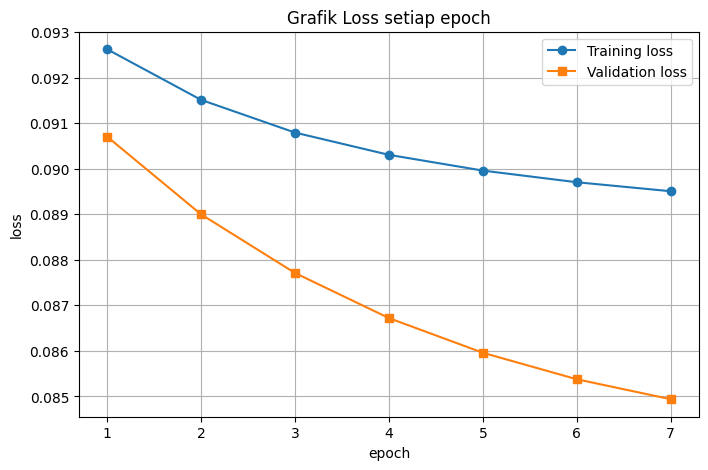

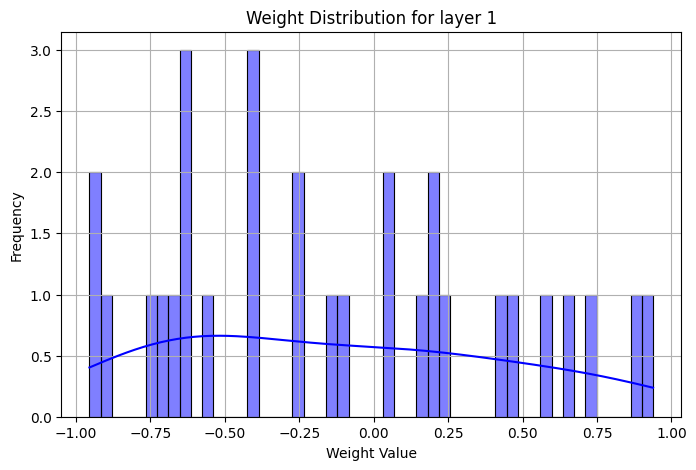

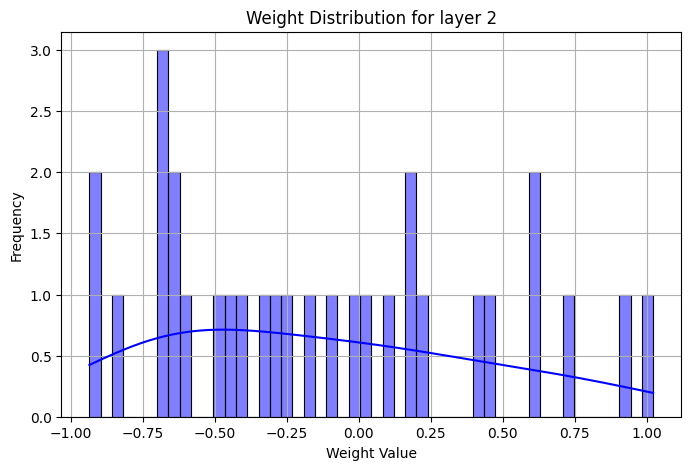

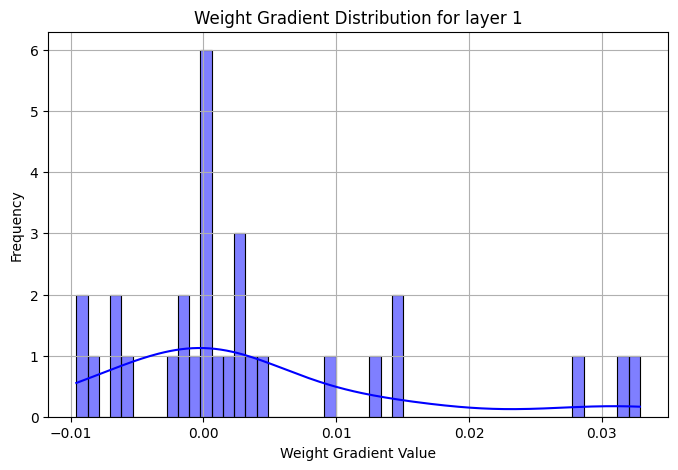

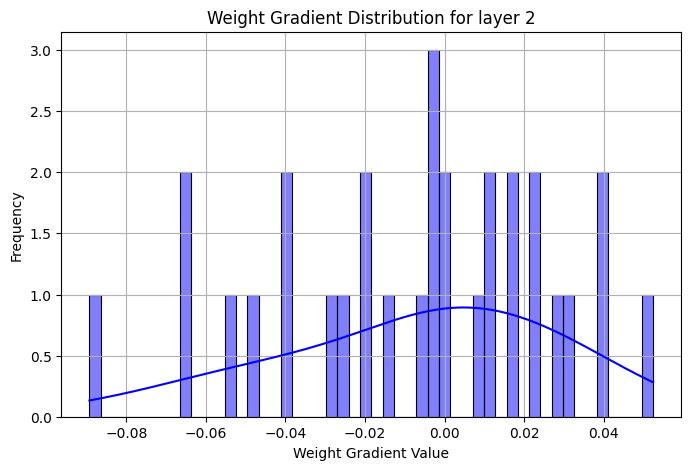

In [66]:
# 3 hidden layer
Depth1 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Depth1.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Depth1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Depth1.weight_distribution([1, 2])
Depth1.gradient_distribution([1, 2])



Epoch 1/5:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 1/5:   0%|          | 0/16 [00:00<?, ?batch/s, Batch Loss=0.0941]

Epoch 1/5:   6%|▋         | 1/16 [00:00<00:03,  3.99batch/s, Batch Loss=0.0886]

Epoch 1/5:  12%|█▎        | 2/16 [00:00<00:01,  7.96batch/s, Batch Loss=0.0886]

Epoch 1/5:  12%|█▎        | 2/16 [00:00<00:01,  7.96batch/s, Batch Loss=0.0922]

Epoch 1/5:  19%|█▉        | 3/16 [00:00<00:04,  2.81batch/s, Batch Loss=0.0922]

Epoch 1/5:  19%|█▉        | 3/16 [00:02<00:04,  2.81batch/s, Batch Loss=0.103] 

Epoch 1/5:  25%|██▌       | 4/16 [00:02<00:09,  1.32batch/s, Batch Loss=0.103]

Epoch 1/5:  25%|██▌       | 4/16 [00:04<00:09,  1.32batch/s, Batch Loss=0.0939]

Epoch 1/5:  31%|███▏      | 5/16 [00:04<00:13,  1.19s/batch, Batch Loss=0.0939]

Epoch 1/5:  31%|███▏      | 5/16 [00:07<00:13,  1.19s/batch, Batch Loss=0.0992]

Epoch 1/5:  38%|███▊      | 6/16 [00:07<00:16,  1.67s/batch, Batch Loss=0.0992]

Epoch 1/5:  38%|███▊      | 6/16 [00:10<00:16,  1.67s/batch, B

Epoch 1: Train Loss = 0.0943156171626623, Val Loss = 0.09164415170130129




Epoch 2/5:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/5:   0%|          | 0/16 [00:00<?, ?batch/s, Batch Loss=0.0927]

Epoch 2/5:   6%|▋         | 1/16 [00:07<01:51,  7.43s/batch, Batch Loss=0.0877]

Epoch 2/5:  12%|█▎        | 2/16 [00:07<00:51,  3.71s/batch, Batch Loss=0.0877]

Epoch 2/5:  12%|█▎        | 2/16 [00:15<00:51,  3.71s/batch, Batch Loss=0.0921]

Epoch 2/5:  19%|█▉        | 3/16 [00:15<01:10,  5.46s/batch, Batch Loss=0.0921]

Epoch 2/5:  19%|█▉        | 3/16 [00:23<01:10,  5.46s/batch, Batch Loss=0.101] 

Epoch 2/5:  25%|██▌       | 4/16 [00:23<01:19,  6.60s/batch, Batch Loss=0.101]

Epoch 2/5:  25%|██▌       | 4/16 [00:32<01:19,  6.60s/batch, Batch Loss=0.0941]

Epoch 2/5:  31%|███▏      | 5/16 [00:32<01:22,  7.46s/batch, Batch Loss=0.0941]

Epoch 2/5:  31%|███▏      | 5/16 [00:42<01:22,  7.46s/batch, Batch Loss=0.0983]

Epoch 2/5:  38%|███▊      | 6/16 [00:42<01:21,  8.17s/batch, Batch Loss=0.0983]

Epoch 2/5:  38%|███▊      | 6/16 [00:52<01:21,  8.17s/batch, B

Epoch 2: Train Loss = 0.09343826786854276, Val Loss = 0.09106856251227628




Epoch 3/5:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/5:   0%|          | 0/16 [00:00<?, ?batch/s, Batch Loss=0.0915]

Epoch 3/5:   6%|▋         | 1/16 [00:14<03:33, 14.25s/batch, Batch Loss=0.087]

Epoch 6/7:  86%|████████▌ | 6/7 [1:24:40<14:06, 846.72s/batch, Batch Loss=nan]


Epoch 3/5:  12%|█▎        | 2/16 [04:20<01:39,  7.12s/batch, Batch Loss=0.0922]

Epoch 3/5:  19%|█▉        | 3/16 [04:20<23:05, 106.56s/batch, Batch Loss=0.0922]

Epoch 3/5:  19%|█▉        | 3/16 [04:36<23:05, 106.56s/batch, Batch Loss=0.1]   

Epoch 3/5:  25%|██▌       | 4/16 [04:36<14:33, 72.81s/batch, Batch Loss=0.1] 

Epoch 3/5:  25%|██▌       | 4/16 [04:52<14:33, 72.81s/batch, Batch Loss=0.0943]

Epoch 3/5:  31%|███▏      | 5/16 [04:52<09:46, 53.31s/batch, Batch Loss=0.0943]

Epoch 3/5:  31%|███▏      | 5/16 [05:10<09:46, 53.31s/batch, Batch Loss=0.0976]

Epoch 3/5:  38%|███▊      | 6/16 [05:10<06:54, 41.45s/batch, Batch Loss=0.0976]

Epoch 3/5:  38%|███▊      | 6/16 [05:28<06:54, 41.45s/batch, B

Epoch 3: Train Loss = 0.09271169286987502, Val Loss = 0.09048227428534535


Epoch 4/5: 100%|██████████| 16/16 [05:58<00:00, 22.38s/batch, Batch Loss=0.093]


Epoch 4: Train Loss = 0.0920903610448373, Val Loss = 0.08988395965897777


Epoch 5/5: 100%|██████████| 16/16 [07:31<00:00, 28.21s/batch, Batch Loss=0.0913]


Epoch 5: Train Loss = 0.09154888712420886, Val Loss = 0.08927794885208111
Prediksi: [3 3 3 3 3]
Kelas sebenarnya: [3 7 1 8 1]
Akurasi: 0.2


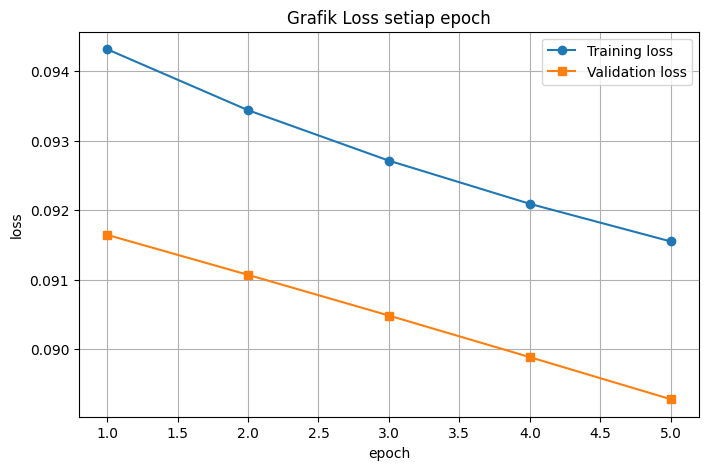

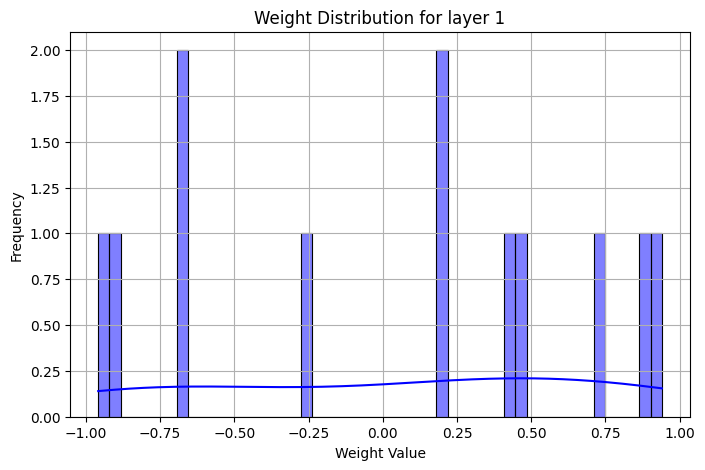

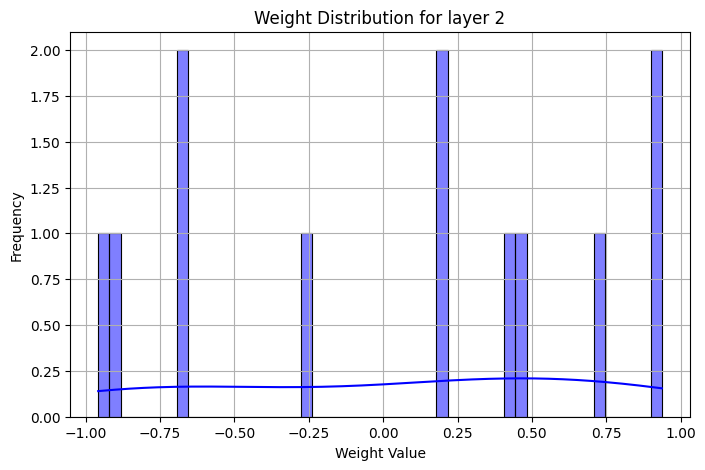

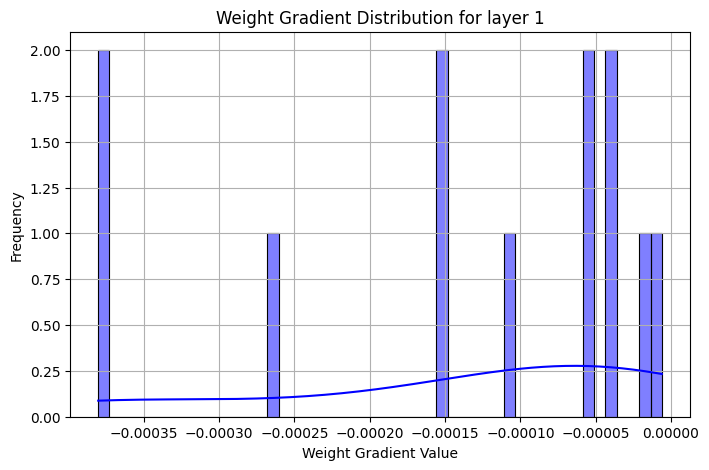

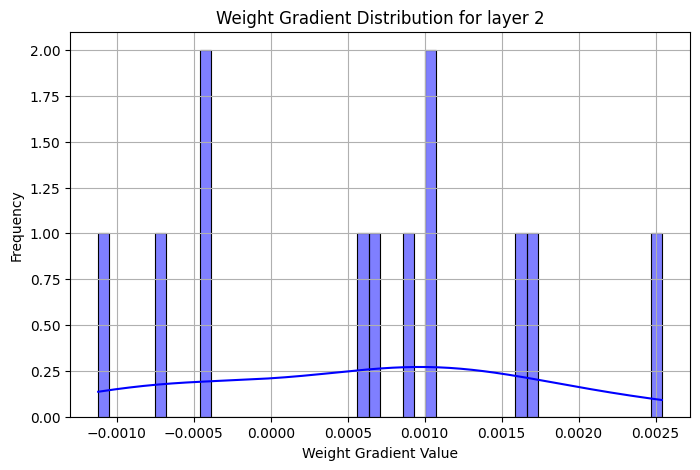

In [65]:
# 5 hidden layer
Depth2 = FFNN(784, [3, 3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (6)])
train_loss, val_loss = Depth2.train_model(2, 0.1, 5, X_train, Y_train, X_val, Y_val, 1)
y_pred = Depth2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Depth2.weight_distribution([1, 2])
Depth2.gradient_distribution([1, 2])

Epoch 1/5: 100%|██████████| 16/16 [00:54<00:00,  3.39s/batch, Batch Loss=0.098]


Epoch 1: Train Loss = 0.0943110638644699, Val Loss = 0.09164082078574966


Epoch 2/5: 100%|██████████| 16/16 [07:29<00:00, 28.12s/batch, Batch Loss=0.0963]


Epoch 2: Train Loss = 0.09343418336504884, Val Loss = 0.091064583711304


Epoch 3/5: 100%|██████████| 16/16 [05:08<00:00, 19.25s/batch, Batch Loss=0.0946]


Epoch 3: Train Loss = 0.09270781582105503, Val Loss = 0.09047740452104854


Epoch 4/5: 100%|██████████| 16/16 [07:30<00:00, 28.16s/batch, Batch Loss=0.0929]


Epoch 4: Train Loss = 0.09208651871958339, Val Loss = 0.08987795120748432


Epoch 5/5: 100%|██████████| 16/16 [09:38<00:00, 36.15s/batch, Batch Loss=0.0913]


Epoch 5: Train Loss = 0.09154495349390228, Val Loss = 0.08927054846265285
Prediksi: [3 3 3 3 3]
Kelas sebenarnya: [3 7 1 8 1]
Akurasi: 0.2


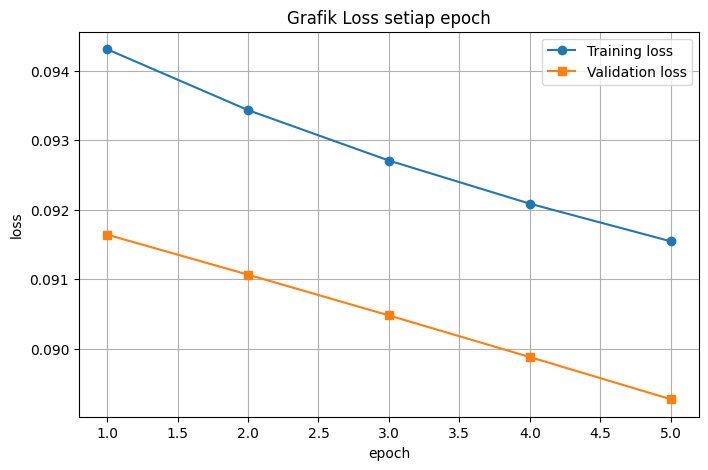

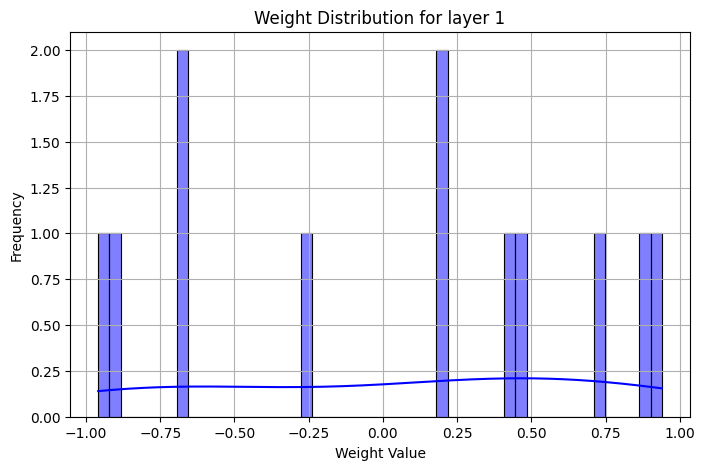

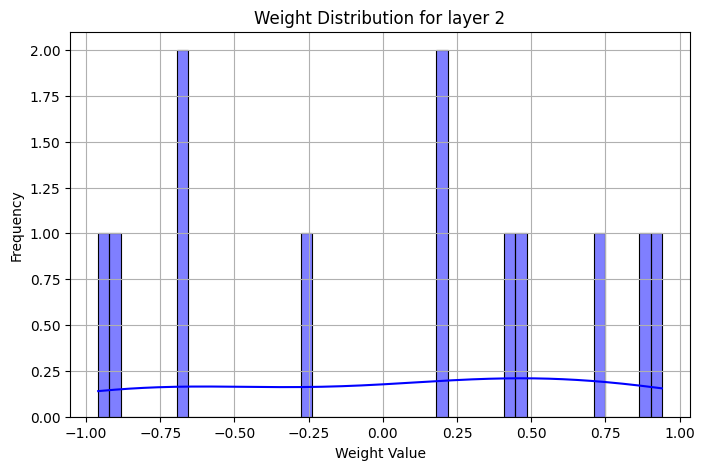

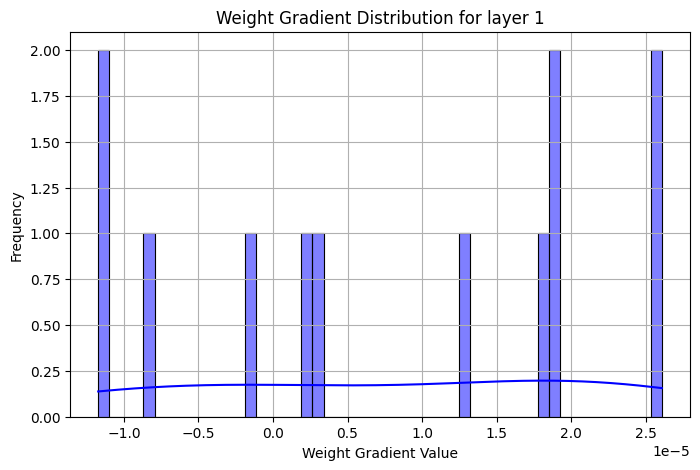

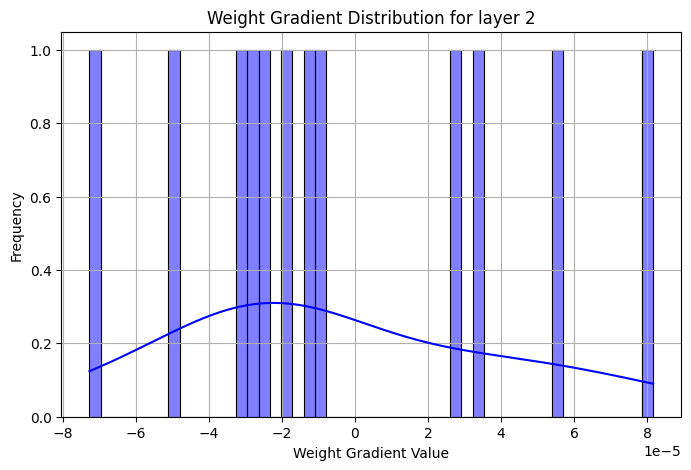

In [67]:
# 7 hidden layer
Depth3 = FFNN(784, [3, 3, 3, 3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (8)])
train_loss, val_loss = Depth3.train_model(2, 0.1, 5, X_train, Y_train, X_val, Y_val, 1)
y_pred = Depth3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Depth3.weight_distribution([1, 2])
Depth3.gradient_distribution([1, 2])

# Test pengaruh width

Epoch 1/5: 100%|██████████| 16/16 [00:34<00:00,  2.14s/batch, Batch Loss=0.098]


Epoch 1: Train Loss = 0.09430144731312641, Val Loss = 0.09158107867815173


Epoch 2/5: 100%|██████████| 16/16 [01:45<00:00,  6.59s/batch, Batch Loss=0.0963]


Epoch 2: Train Loss = 0.09342388366919209, Val Loss = 0.09100403609902923


Epoch 3/5: 100%|██████████| 16/16 [02:57<00:00, 11.11s/batch, Batch Loss=0.0946]


Epoch 3: Train Loss = 0.09269696208454616, Val Loss = 0.09041519526263424


Epoch 4/5: 100%|██████████| 16/16 [07:45<00:00, 29.12s/batch, Batch Loss=0.0929]


Epoch 4: Train Loss = 0.0920750828867863, Val Loss = 0.08981320494370056


Epoch 5/5: 100%|██████████| 16/16 [05:31<00:00, 20.69s/batch, Batch Loss=0.0912]


Epoch 5: Train Loss = 0.09153283080029681, Val Loss = 0.08920237294451842
Prediksi: [3 3 3 3 3]
Kelas sebenarnya: [3 7 1 8 1]
Akurasi: 0.2


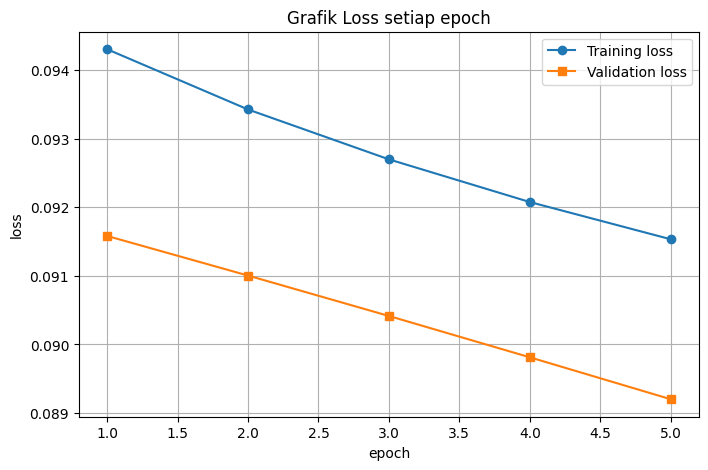

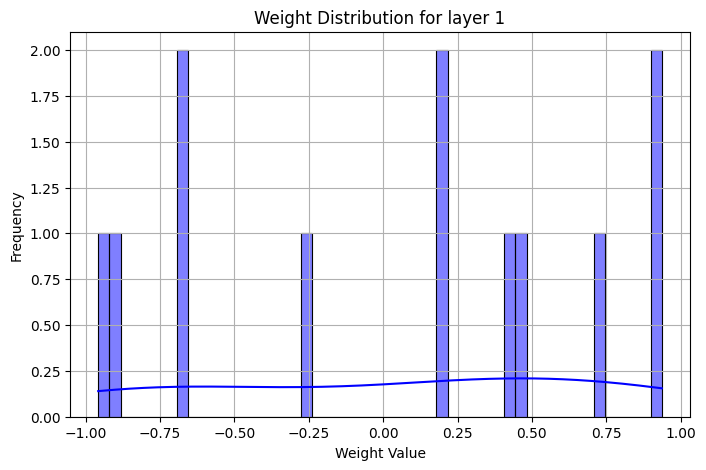

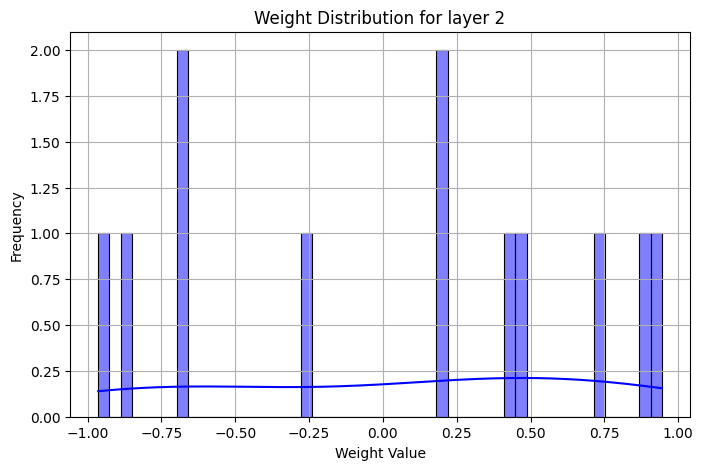

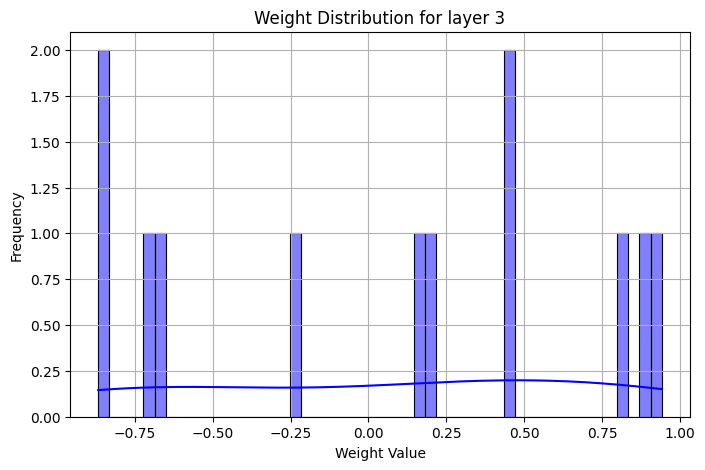

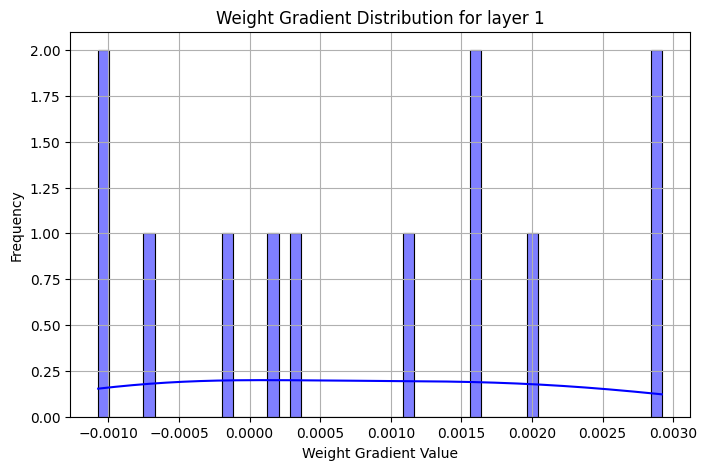

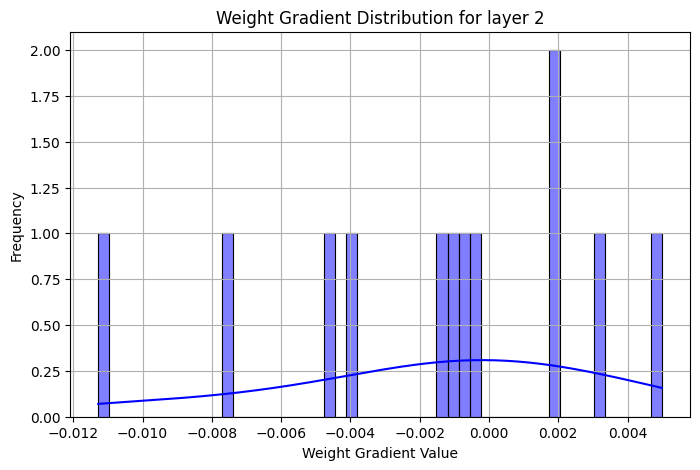

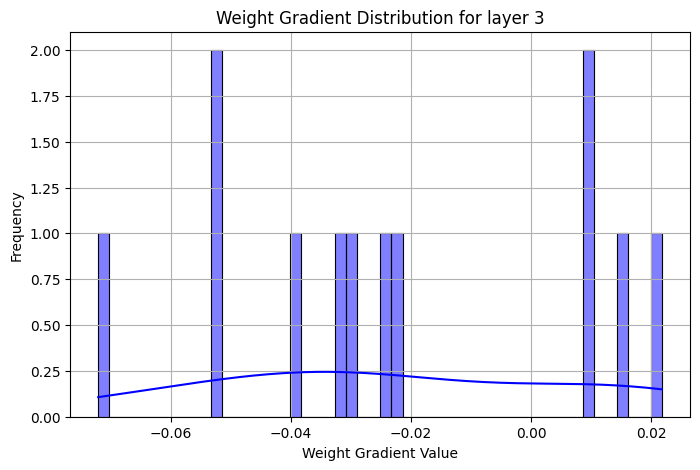

In [68]:
# 3 neuron per layer
Width1 = FFNN(784, [3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width1.train_model(2, 0.1, 5, X_train, Y_train, X_val, Y_val, 1)
y_pred = Width1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Width1.weight_distribution([1, 2, 3])
Width1.gradient_distribution([1, 2, 3])

Epoch 1/5: 100%|██████████| 16/16 [01:01<00:00,  3.85s/batch, Batch Loss=0.0893]


Epoch 1: Train Loss = 0.09288829793649102, Val Loss = 0.09179584025311156


Epoch 2/5: 100%|██████████| 16/16 [03:07<00:00, 11.74s/batch, Batch Loss=0.0861]


Epoch 2: Train Loss = 0.09176318120647592, Val Loss = 0.09010524711353063


Epoch 3/5: 100%|██████████| 16/16 [05:11<00:00, 19.49s/batch, Batch Loss=0.0835]


Epoch 3: Train Loss = 0.09103797226903479, Val Loss = 0.08883554573769625


Epoch 4/5: 100%|██████████| 16/16 [07:19<00:00, 27.46s/batch, Batch Loss=0.0814]


Epoch 4: Train Loss = 0.09054621014810027, Val Loss = 0.08786242416354463


Epoch 5/5: 100%|██████████| 16/16 [16:41<00:00, 62.56s/batch, Batch Loss=0.0797]


Epoch 5: Train Loss = 0.09019951775816648, Val Loss = 0.08711489815808093
Prediksi: [1 1 1 1 1]
Kelas sebenarnya: [3 7 1 8 1]
Akurasi: 0.4


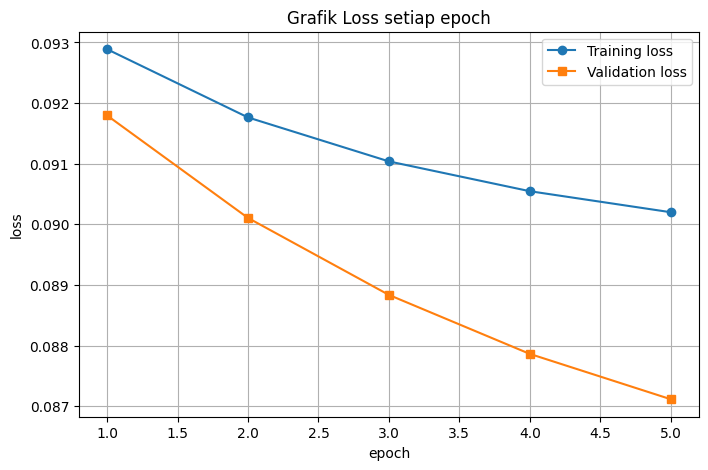

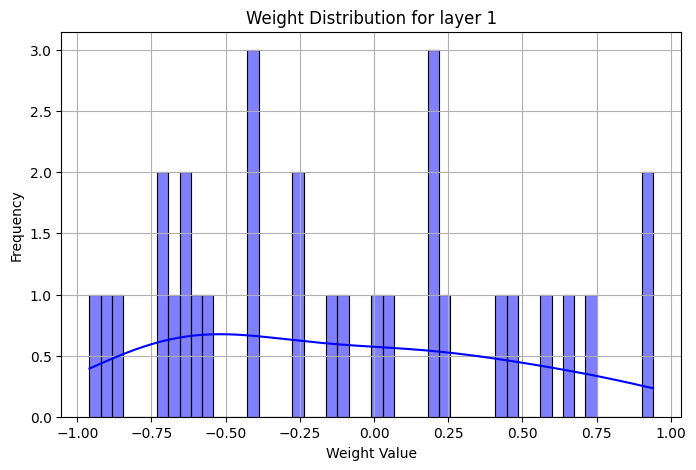

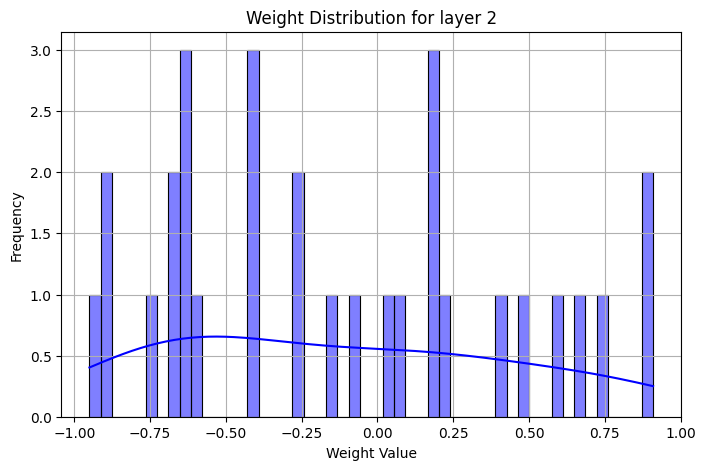

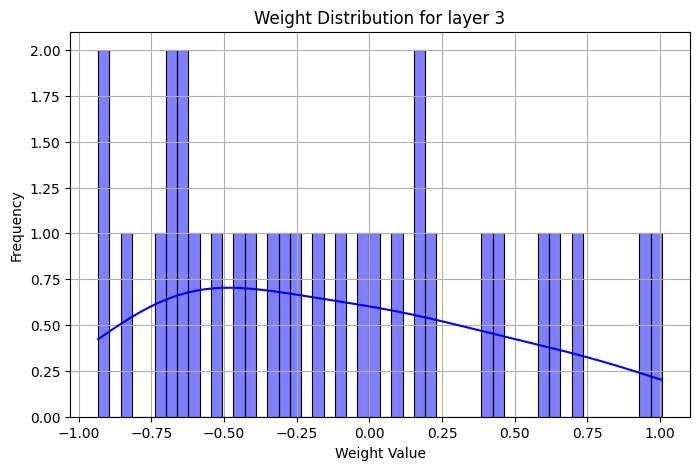

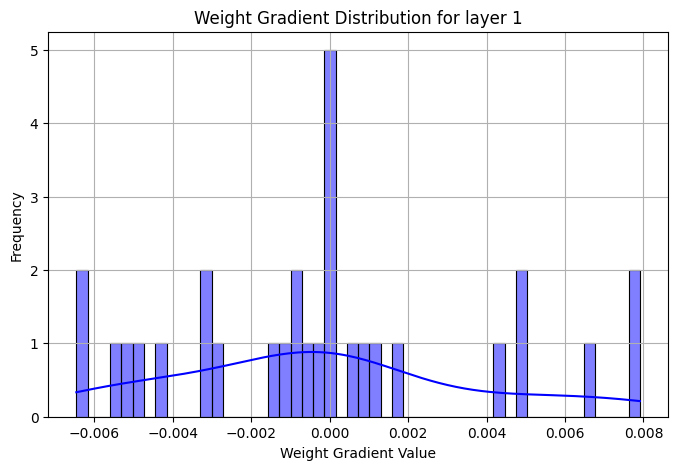

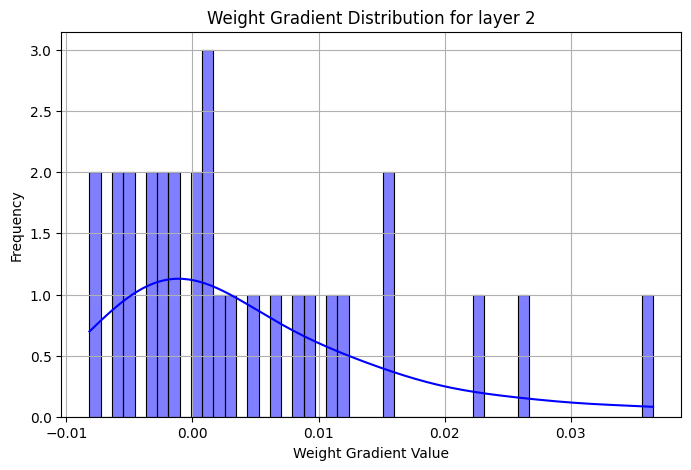

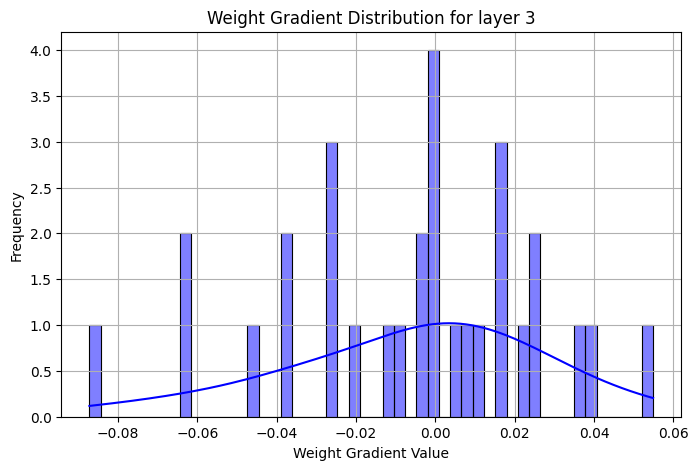

In [69]:
# 5 neuron per layer
Width2 = FFNN(784, [5, 5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width2.train_model(2, 0.1, 5, X_train, Y_train, X_val, Y_val, 1)
y_pred = Width2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Width2.weight_distribution([1, 2, 3])
Width2.gradient_distribution([1, 2, 3])

Epoch 1/5: 100%|██████████| 16/16 [02:24<00:00,  9.04s/batch, Batch Loss=0.0831]


Epoch 1: Train Loss = 0.09460603241573799, Val Loss = 0.08512029444495672


Epoch 2/5: 100%|██████████| 16/16 [06:53<00:00, 25.87s/batch, Batch Loss=0.0782]


Epoch 2: Train Loss = 0.09256884601013214, Val Loss = 0.08301285532261345


Epoch 3/5: 100%|██████████| 16/16 [11:14<00:00, 42.16s/batch, Batch Loss=0.0758]


Epoch 3: Train Loss = 0.09187139935772116, Val Loss = 0.0819928745098555


Epoch 4/5: 100%|██████████| 16/16 [20:43<00:00, 77.70s/batch, Batch Loss=0.0746]


Epoch 4: Train Loss = 0.09146818071008521, Val Loss = 0.0815171235949967


Epoch 5/5: 100%|██████████| 16/16 [20:57<00:00, 78.61s/batch, Batch Loss=0.0741]


Epoch 5: Train Loss = 0.09115637054155629, Val Loss = 0.08133178086593384
Prediksi: [1 1 1 1 1]
Kelas sebenarnya: [3 7 1 8 1]
Akurasi: 0.4


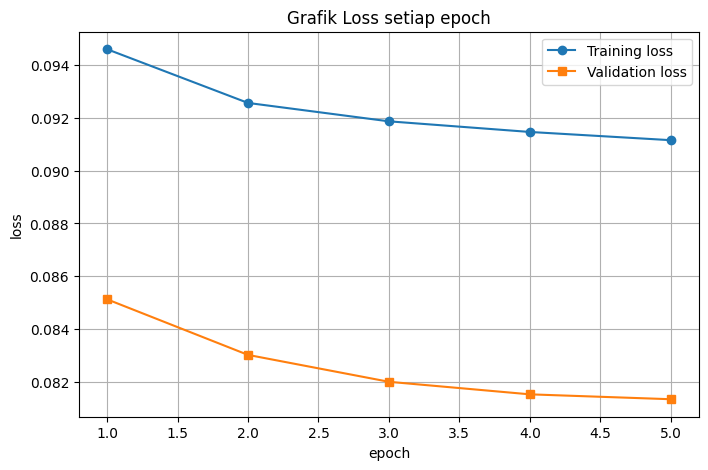

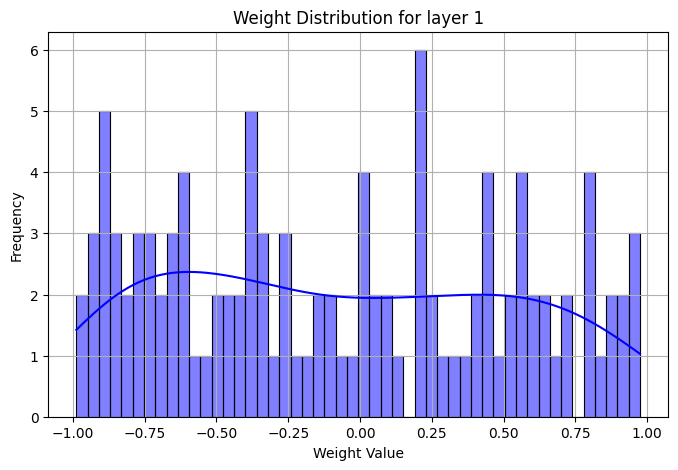

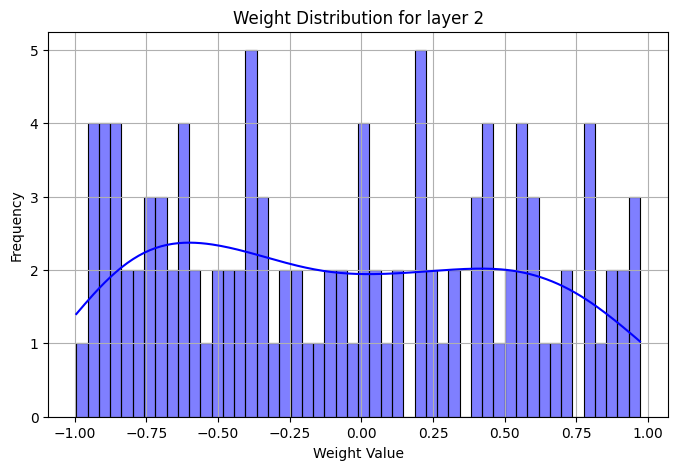

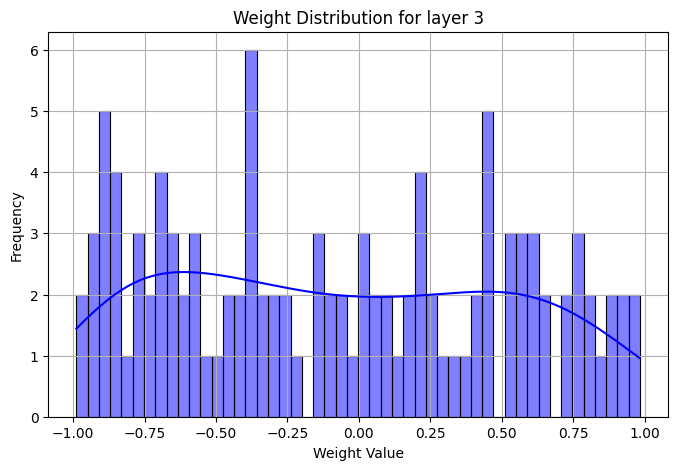

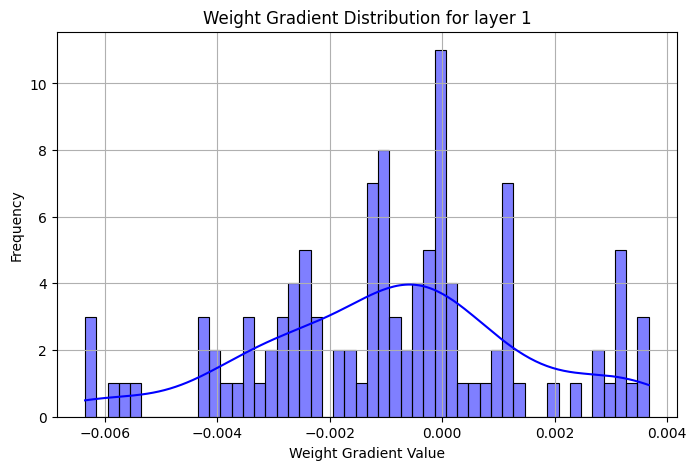

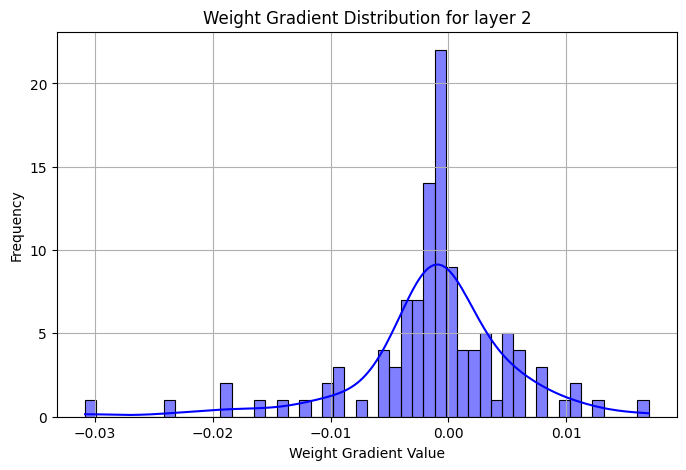

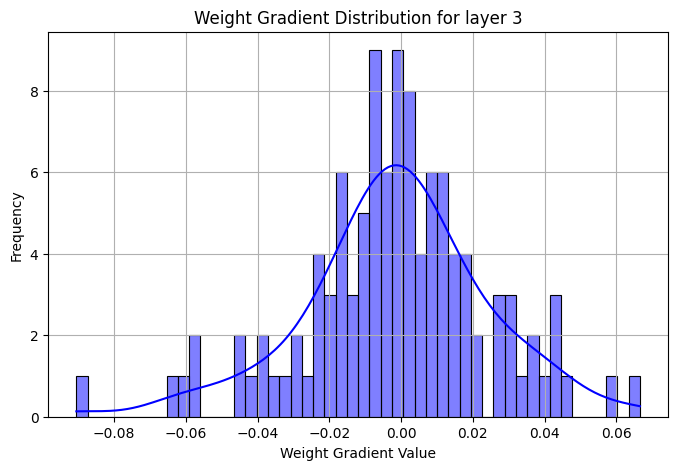

In [70]:
# 10 neuron per layer
Width3 = FFNN(784, [10, 10, 10, 10], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width3.train_model(2, 0.1, 5, X_train, Y_train, X_val, Y_val, 1)
y_pred = Width3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Width3.weight_distribution([1, 2, 3])
Width3.gradient_distribution([1, 2, 3])

# Test pengaruh fungsi aktivasi

Epoch 1/3: 100%|██████████| 7/7 [00:05<00:00,  1.20batch/s, Batch Loss=15.6]


Epoch 1: Train Loss = 7.984361206080671, Val Loss = 2.9622972183616527


Epoch 2/3: 100%|██████████| 7/7 [00:19<00:00,  2.78s/batch, Batch Loss=19.9]


Epoch 2: Train Loss = 10.310691276363492, Val Loss = 13.8849059394525


Epoch 3/3: 100%|██████████| 7/7 [00:33<00:00,  4.79s/batch, Batch Loss=23]

Epoch 3: Train Loss = 17.1873807159552, Val Loss = 23.025850929940457
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


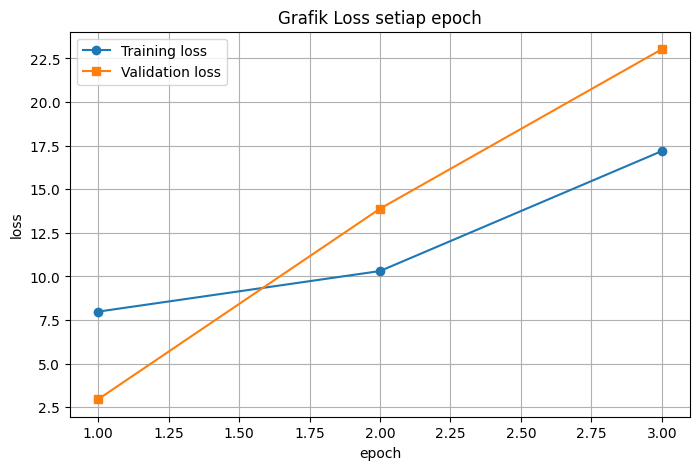

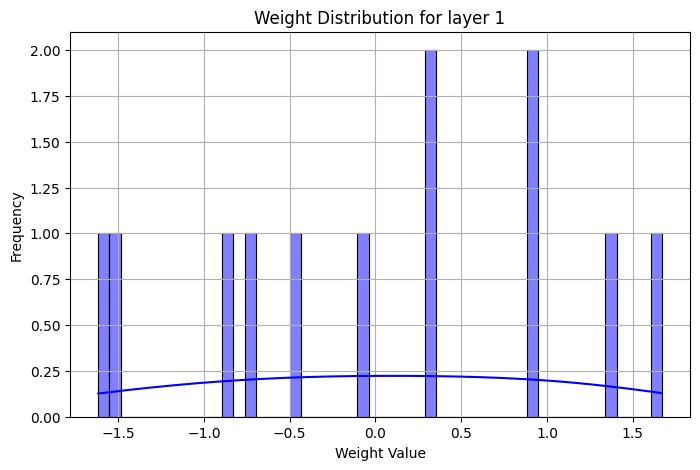

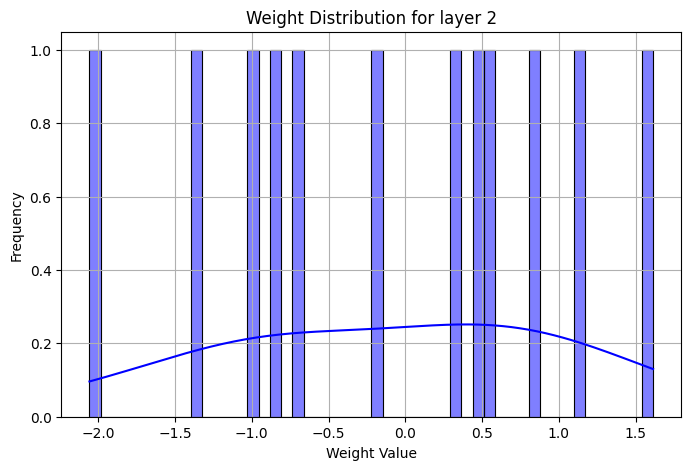

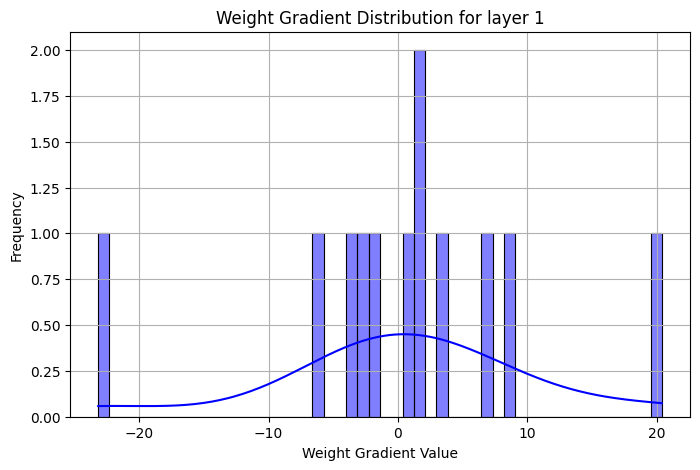

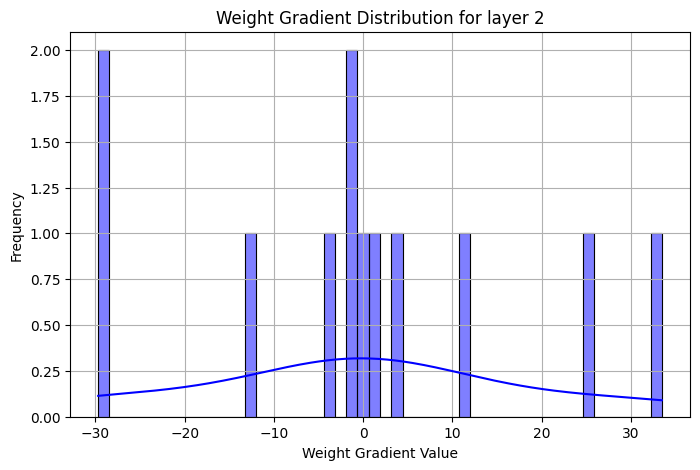

In [88]:
# linear
fn_linear = FFNN(784, [3, 3, 3], 10, ["linear", "linear", "linear", "softmax"], "cce", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_linear.train_model(2, 0.01, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_linear.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_linear.weight_distribution([1, 2])
fn_linear.gradient_distribution([1, 2])

In [ ]:
# relu
fn_relu = FFNN(784, [5, 5, 5], 10, ["relu", "relu", "relu", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_relu.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_relu.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_relu.weight_distribution([1, 2])
fn_relu.gradient_distribution([1, 2])

In [ ]:
# sigmoid
fn_sigmoid = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_sigmoid.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_sigmoid.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_sigmoid.weight_distribution([1, 2])
fn_sigmoid.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, Batch Loss=0.111]


Epoch 1: Train Loss = 0.09142302012112731, Val Loss = 0.08156864408378933


Epoch 2/3: 100%|██████████| 7/7 [03:29<00:00, 29.90s/batch, Batch Loss=0.112]


Epoch 2: Train Loss = 0.0959943435394187, Val Loss = 0.08571330910629835


Epoch 3/3: 100%|██████████| 7/7 [00:32<00:00,  4.67s/batch, Batch Loss=0.112]

Epoch 3: Train Loss = 0.0953184285183429, Val Loss = 0.08601564826213282
Prediksi: [5 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


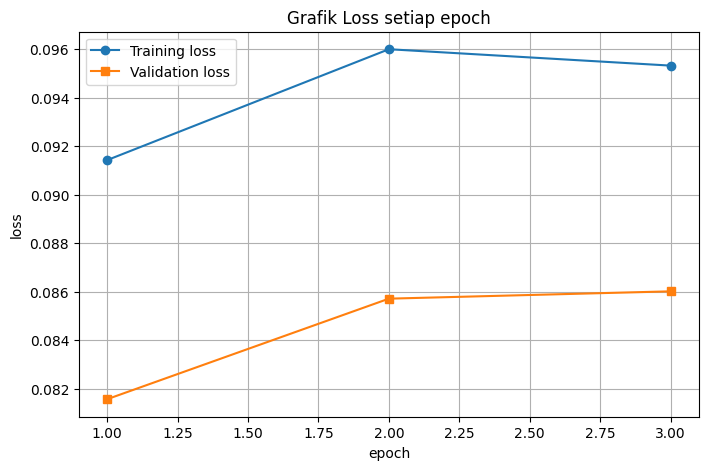

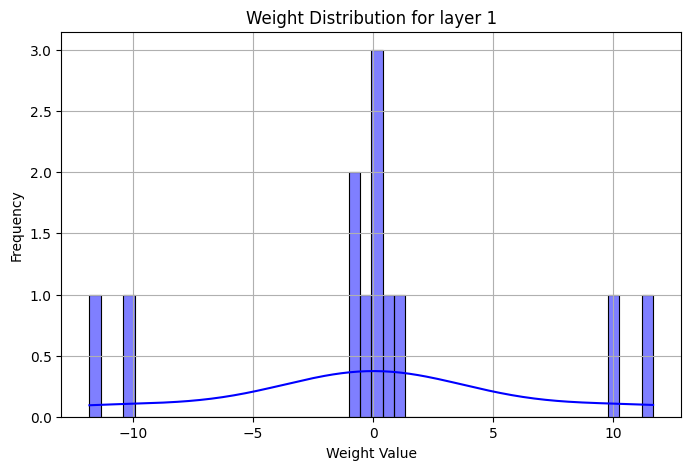

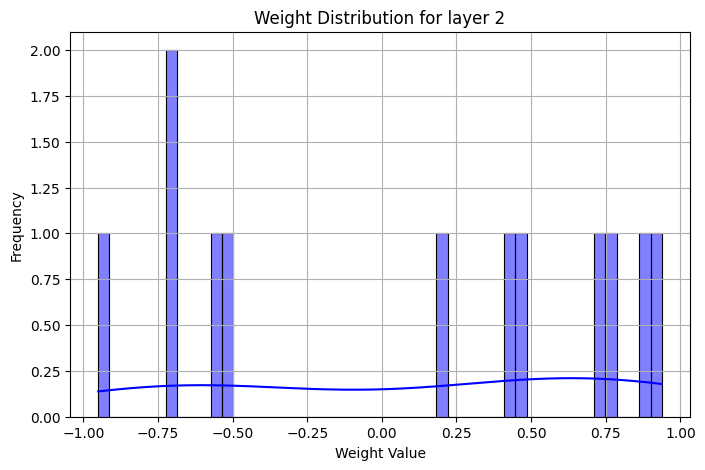

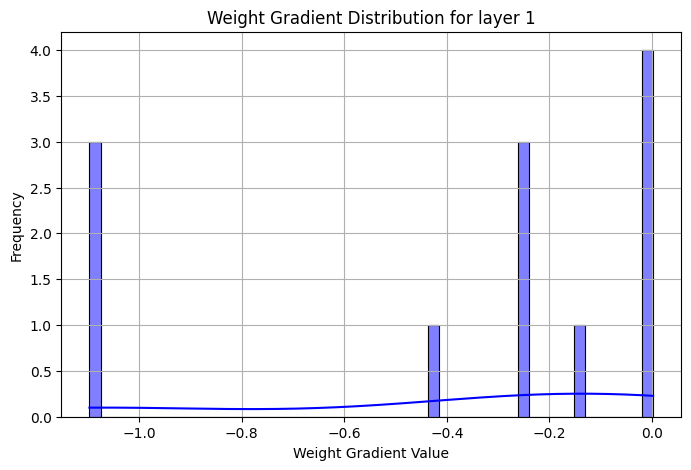

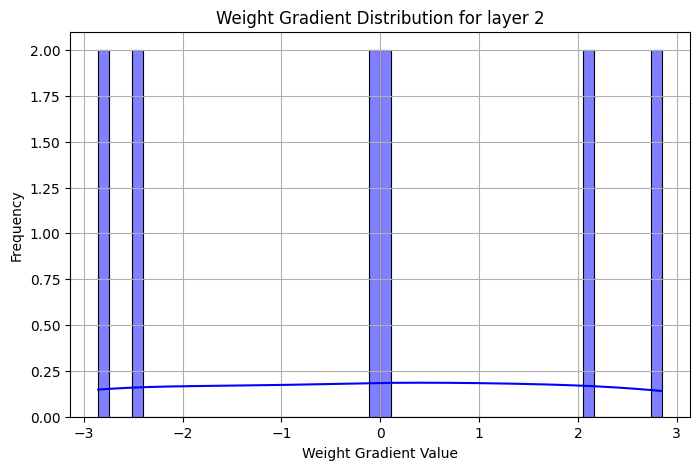

In [85]:
# tanh
fn_tanh = FFNN(784, [3, 3, 3], 10, ["tanh", "tanh", "tanh", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_tanh.train_model(2, 0.001, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_tanh.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_tanh.weight_distribution([1, 2])
fn_tanh.gradient_distribution([1, 2])

# Test pengaruh learning rate

In [ ]:
# 0.01
Learn1 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Learn1.train_model(2, 0.01, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Learn1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Learn1.weight_distribution([1, 2])
Learn1.gradient_distribution([1, 2])

In [ ]:
# 0.1
Learn2 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Learn2.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Learn2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Learn2.weight_distribution([1, 2])
Learn2.gradient_distribution([1, 2])

In [ ]:
# 10
Learn3 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Learn3.train_model(2, 10, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Learn3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Learn3.weight_distribution([1, 2])
Learn3.gradient_distribution([1, 2])

# Test pengaruh inisialisasi bobot

In [ ]:
# zero
Weight1 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("zero", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Weight1.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight1.weight_distribution([1, 2])
Weight1.gradient_distribution([1, 2])

In [ ]:
# uniform
Weight2 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Weight2.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight2.weight_distribution([1, 2])
Weight2.gradient_distribution([1, 2])

In [ ]:
# normal
Weight3 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("normal", 0, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Weight3.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight3.weight_distribution([1, 2])
Weight3.gradient_distribution([1, 2])

In [ ]:
# xavier uniform
Weight4 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "xavier") for _ in range (4)])
train_loss, val_loss = Weight4.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight4.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight4.weight_distribution([1, 2])
Weight4.gradient_distribution([1, 2])

In [ ]:
# xavier normal
Weight5 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("normal", 0, 1, 42, "xavier") for _ in range (4)])
train_loss, val_loss = Weight5.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight5.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight5.weight_distribution([1, 2])
Weight5.gradient_distribution([1, 2])

In [ ]:
# he uniform
Weight6 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "he") for _ in range (4)])
train_loss, val_loss = Weight6.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight6.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight6.weight_distribution([1, 2])
Weight6.gradient_distribution([1, 2])

In [ ]:
# he normal
Weight7 = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("normal", 0, 1, 42, "he") for _ in range (4)])
train_loss, val_loss = Weight7.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight7.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight7.weight_distribution([1, 2])
Weight7.gradient_distribution([1, 2])

# Test pengaruh regularisasi

Epoch 1/3: 100%|██████████| 7/7 [00:05<00:00,  1.18batch/s, Batch Loss=0.25]


Epoch 1: Train Loss = 0.2411091789984353, Val Loss = 0.2292017896106585


Epoch 2/3: 100%|██████████| 7/7 [00:18<00:00,  2.64s/batch, Batch Loss=0.249]


Epoch 2: Train Loss = 0.24027058677979185, Val Loss = 0.22957965291517748


Epoch 3/3: 100%|██████████| 7/7 [00:31<00:00,  4.45s/batch, Batch Loss=0.248]

Epoch 3: Train Loss = 0.23953588164786133, Val Loss = 0.23000327427266007
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


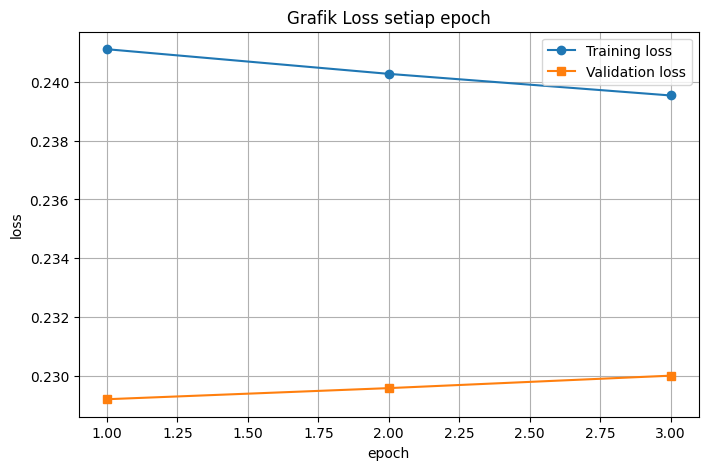

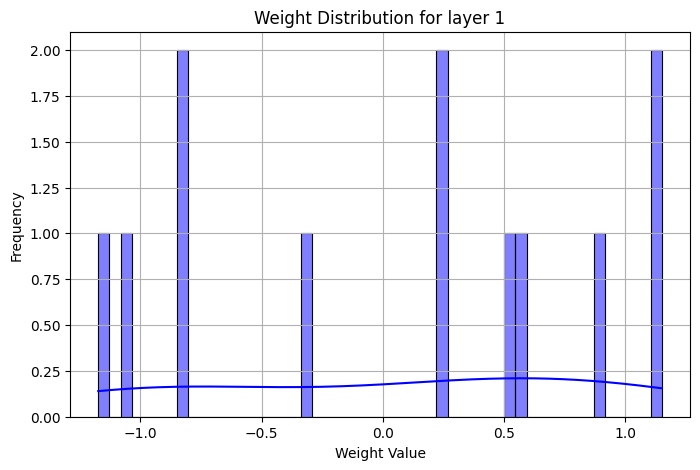

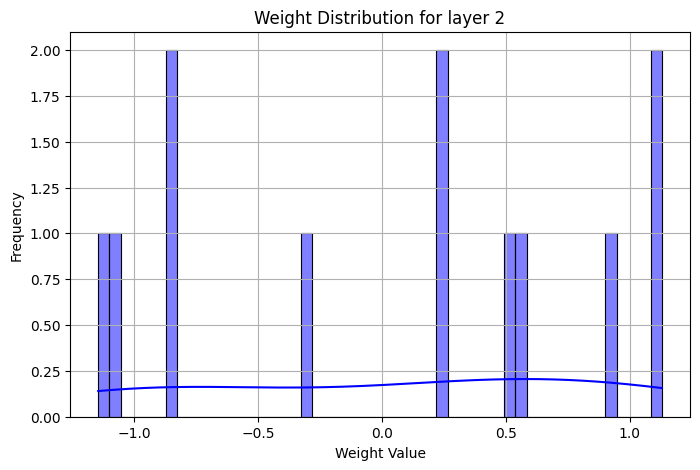

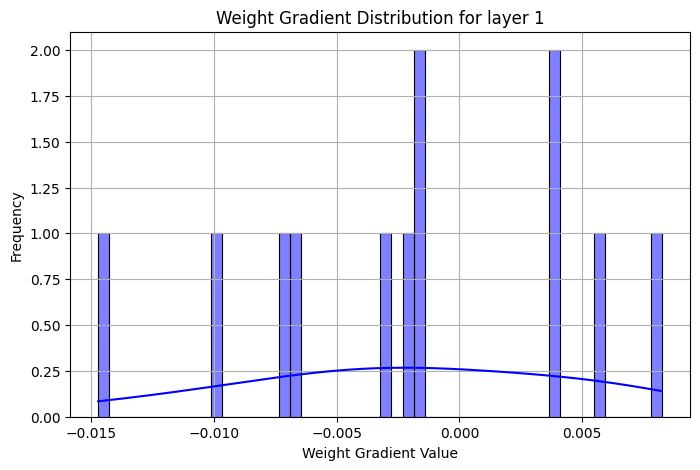

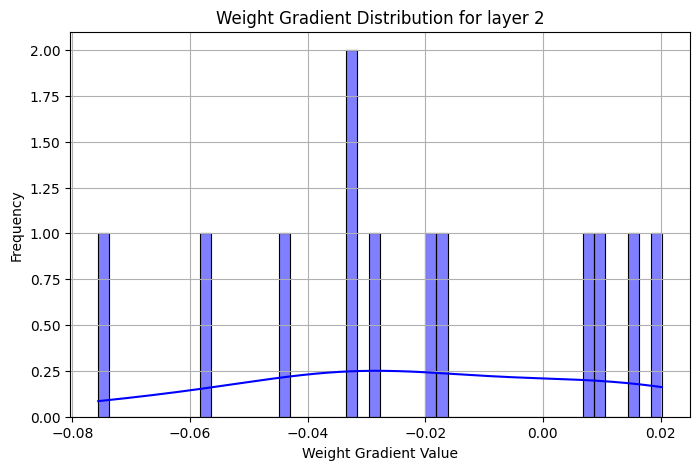

In [76]:
# L1
Weight6 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "he") for _ in range (4)], regularization="L1", lambda_=0.001)
train_loss, val_loss = Weight6.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight6.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight6.weight_distribution([1, 2])
Weight6.gradient_distribution([1, 2])

In [25]:
# L2
Weight6 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "he") for _ in range (4)], regularization="L2", lambda_=0.001)
train_loss, val_loss = Weight6.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight6.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight6.weight_distribution([1, 2])
Weight6.gradient_distribution([1, 2])

KeyboardInterrupt: 

# test perbandingan sklearn

In [37]:
# manual
manual = FFNN(784, [5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = manual.train_model(2, 0.1, 7, X_train, Y_train, X_val, Y_val, 1)
y_pred = manual.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))

Epoch 1/7: 100%|██████████| 14/14 [01:11<00:00,  5.14s/batch, Batch Loss=0.0987]


Epoch 1: Train Loss = 0.09271511245739096, Val Loss = 0.0894888900831522


Epoch 2/7: 100%|██████████| 14/14 [03:29<00:00, 14.99s/batch, Batch Loss=0.0967]


Epoch 2: Train Loss = 0.09181082396874517, Val Loss = 0.08834854561843034


Epoch 3/7: 100%|██████████| 14/14 [06:00<00:00, 25.73s/batch, Batch Loss=0.095]


Epoch 3: Train Loss = 0.09118387694915357, Val Loss = 0.08753884144012497


Epoch 4/7: 100%|██████████| 14/14 [06:51<00:00, 29.37s/batch, Batch Loss=0.0935]


Epoch 4: Train Loss = 0.09072833644735279, Val Loss = 0.08695233215019565


Epoch 5/7: 100%|██████████| 14/14 [11:51<00:00, 50.81s/batch, Batch Loss=0.0923]


Epoch 5: Train Loss = 0.09039063738166779, Val Loss = 0.08652546155438262


Epoch 6/7: 100%|██████████| 14/14 [11:17<00:00, 48.38s/batch, Batch Loss=0.0913]


Epoch 6: Train Loss = 0.09013656975310137, Val Loss = 0.0862143975810194


Epoch 7/7: 100%|██████████| 14/14 [12:58<00:00, 55.63s/batch, Batch Loss=0.0905]


Epoch 7: Train Loss = 0.089941471654204, Val Loss = 0.08598683570470383
Prediksi: [1 1 1 1]
Kelas sebenarnya: [4 2 1 0]
Akurasi: 0.25


In [8]:
model = MLPClassifier(
    hidden_layer_sizes=(5, 5, 5),
    activation='logistic', # sigmoid
    batch_size=2,
    learning_rate_init=0.1,
    max_iter=7,  # epochs
    random_state=42
)

# Train the model
model.fit(X_train, Y_train)

# Predict and evaluate
y_pred = model.predict_proba(X_val)
y_pred = np.argmax(y_pred, axis=1)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))

Prediksi: [3 1 1 1]
Kelas sebenarnya: [4 2 1 0]
Akurasi: 0.25


C:\Users\devin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(
